In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 26.7 MB/s 
     |████████████████████████████████| 209 kB 57.6 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 112 kB 65.0 MB/s 
     |████████████████████████████████| 147 kB 66.3 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=2ceff20701908ce2ab38c383a3e57e71fc88fd8846b6bc51737a18c231297ae3
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

import os
import optuna

In [3]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

###############   Transforming Data #################
train_transform = transforms.Compose([
    
    transforms.ToTensor(),
    # transforms.Normalize((0.5,),(0.5,)),

])
test_transform = transforms.Compose([

    transforms.ToTensor(),
    # transforms.Normalize((0.5,),(0.5,)),
])




train_dataset.transform = train_transform
test_dataset.transform = test_transform



train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

#### Dispalying ####

img, label= next(iter(train_dataloader))
print(f'Image Shape : {img.shape}')
print(f'Label Shape : {img.shape}')

print("----------Label Shape---------------")

img, label= next(iter(test_dataloader))
print(f'Image Shape : {img.shape}')
print(f'Label Shape : {img.shape}')


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw

Image Shape : torch.Size([256, 1, 28, 28])
Label Shape : torch.Size([256, 1, 28, 28])
----------Label Shape---------------
Image Shape : torch.Size([10000, 1, 28, 28])
Label Shape : torch.Size([10000, 1, 28, 28])


In [4]:
## ENCODER 


class Encoder(nn.Module):
  def __init__(self, encoded_space_dim , convh , linh):
    super().__init__()
    print("Encoder Initializing !")

    self.conv2d = nn.Sequential(
                  nn.Conv2d(in_channels=1, out_channels=convh, kernel_size=3, stride=2, padding=1),
                  nn.ReLU(),

                  nn.Conv2d(in_channels=convh, out_channels=2*convh , kernel_size=3, stride=2, padding=1),
                  nn.ReLU(),

                  nn.Conv2d(in_channels=2*convh, out_channels=4*convh, kernel_size=3, stride=2, padding=0),
                  nn.ReLU(),
                  
                  )
    self.flatten = nn.Flatten(start_dim =1 )
    self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*4*convh, out_features=linh),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=linh, out_features=encoded_space_dim)
        )
    

  def forward(self, x ):
      x = self.conv2d(x)
      x = self.flatten(x)
      x = self.encoder_lin(x)

      return x


 ## DECODER

class Decoder (nn.Module):
  def __init__(self,encoded_space_dim , convh , linh):

    super(). __init__()
    print("Decoder Initialized !")

    self.decoder_lin = nn.Sequential(
            nn.Linear(in_features=encoded_space_dim, out_features=linh),
            nn.ReLU(True),

            nn.Linear(in_features=linh, out_features=3*3*4*convh),
            nn.ReLU(True),
        )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(4*convh, 3, 3))
    
    self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4*convh, out_channels=2*convh, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=2*convh, out_channels=convh, kernel_size=3,  stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
 
            nn.ConvTranspose2d(in_channels=convh, out_channels=1, kernel_size=3,  stride=2, padding=1, output_padding=1)
        )
    

  def forward(self , x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

In [5]:
convh = 16
linh = 64
encoded_space_dim = 2

encoder = Encoder(encoded_space_dim , convh , linh)
decoder = Decoder(encoded_space_dim , convh , linh)



img, _ = test_dataset[0]
img = img.unsqueeze(0)
print('\n\nOriginal image shape:', img.shape)


img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Encoder Initializing !
Decoder Initialized !


Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device} \n')

encoder.to(device)
decoder.to(device)

Selected device: cuda 



Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=576, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [7]:
class TrainVal():
  def __init__(self, net ,device , loss, optim):
    self.encoder = net['encoder']
    self.decoder = net['decoder']

    self.device = device
    self.loss = loss
    self.optimizer = optim

  def train_step(self,dataloader):
    self.encoder.train()
    self.decoder.train()
    total_loss =0

    for image_batch, _ in train_dataloader: 

      image_batch = image_batch.to(self.device)
      encoded_data = self.encoder(image_batch)
      decoded_data = self.decoder(encoded_data)
      loss = self.loss(decoded_data, image_batch)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      total_loss += loss.item()
    return total_loss / len(train_dataloader)
      
  def validation_step(self , valid_dataloader):

    valid_loss = 0
    self.encoder.eval()
    self.decoder.eval()

    with torch.no_grad(): 

      for image_batch, _ in test_dataloader:
        image_batch = image_batch.to(self.device)
        encoded_data = self.encoder(image_batch)
        decoded_data = self.decoder(encoded_data)
        loss = self.loss(decoded_data, image_batch)

        valid_loss += loss.item()
      return valid_loss / len(valid_dataloader)


In [8]:
loss_fn = torch.nn.MSELoss()
# lr = 5e-4 
# parameters ={
#       "convh": 16,
#       "linh" : 64,
#       "lr" : 0.001,
#       "encoded_space_dim": 10


#   }


epochs = 30
encoder = Encoder(encoded_space_dim , convh , linh)
decoder = Decoder(encoded_space_dim , convh , linh)


def train_model(parameters, device,epochs, loss_fn = loss_fn ):

  encoder = Encoder(parameters['encoded_space_dim']  , parameters['convh'] , parameters['linh']).to(device)
  decoder = Decoder(parameters['encoded_space_dim'] , parameters['convh'] , parameters['linh']).to(device)
  params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
    ]
  optim = torch.optim.Adam(params_to_optimize, lr=parameters['lr'], weight_decay=1e-5 )

  nets = {"encoder" : encoder , "decoder" : decoder}
  model = TrainVal(nets ,device , loss_fn, optim)

  train_loss_log = []
  val_loss_log = []

  best_loss=np.inf
  early_stopping = 5
  early_stopping_counter=0
  save_model_state=True

  for epoch in range(epochs):

    train_loss = model.train_step(train_dataloader)
    valid_loss = model.validation_step(test_dataloader)

    train_loss_log.append(train_loss)
    val_loss_log.append(valid_loss)

    print("-----------------------")
    print(f"##  Epoch : {epoch}  ##")
    print("-----------------------")

    print(f' Training Loss {train_loss}  Validation Loss {valid_loss}')


    if valid_loss < best_loss:
      best_loss = valid_loss
      early_stopping_counter = 0
    if save_model_state:
      torch.save(nets["encoder"].state_dict(), f'model_encoder.bin')
      torch.save(nets["decoder"].state_dict(), f'decoder_state.bin')
    else :
        early_stopping_counter+=1
    if early_stopping_counter>early_stopping:
        break


    if (epoch % 5) == 0:

      test_img = test_dataset[0][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
          decoded_img  = decoder(encoder(test_img))

      print("reconstructed shape ",test_img.shape)
      print("reconstructed shape ",decoded_img.shape)

      fig, axs = plt.subplots(1, 2, figsize=(12,6))
      axs[0].imshow(test_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Original image')
      axs[1].imshow(decoded_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Decoded image (EPOCH %d)' % (epoch + 1))
      plt.tight_layout()
      plt.pause(0.1)
      # Save figures
      os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
      fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
      plt.show()
      plt.close()
  print("\n---------------- Ploting Training and Validation Loss ----------------\n")
  print(train_loss_log[-1])
  print(val_loss_log[-1])

  # Plot losses of the best model
  plt.figure(figsize=(8,6))
  plt.semilogy(train_loss_log, label='Train loss')
  plt.semilogy(val_loss_log, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


  return train_loss

Encoder Initializing !
Decoder Initialized !


Encoder Initializing !
Decoder Initialized !
-----------------------
##  Epoch : 0  ##
-----------------------
 Training Loss 0.06562653203752447  Validation Loss 0.027782130986452103
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


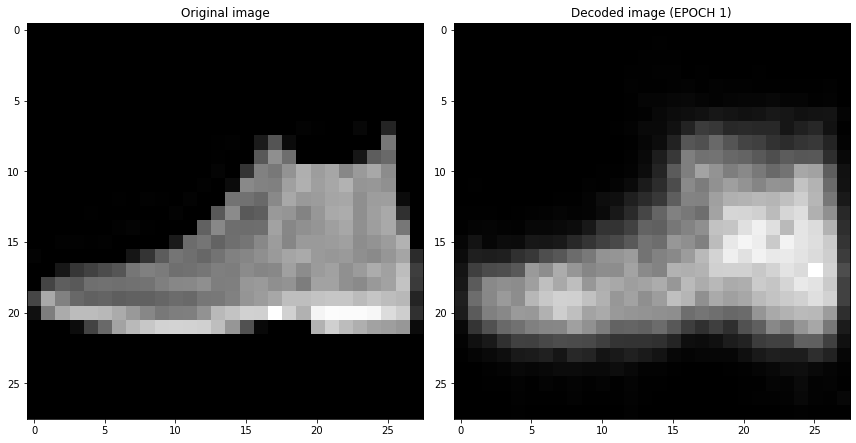

-----------------------
##  Epoch : 1  ##
-----------------------
 Training Loss 0.024057809739036762  Validation Loss 0.021883517503738403
-----------------------
##  Epoch : 2  ##
-----------------------
 Training Loss 0.020861138926541553  Validation Loss 0.020098570734262466
-----------------------
##  Epoch : 3  ##
-----------------------
 Training Loss 0.01964666952002556  Validation Loss 0.01926359534263611
-----------------------
##  Epoch : 4  ##
-----------------------
 Training Loss 0.018881341386982733  Validation Loss 0.018673229962587357
-----------------------
##  Epoch : 5  ##
-----------------------
 Training Loss 0.01834393860970406  Validation Loss 0.018257159739732742
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


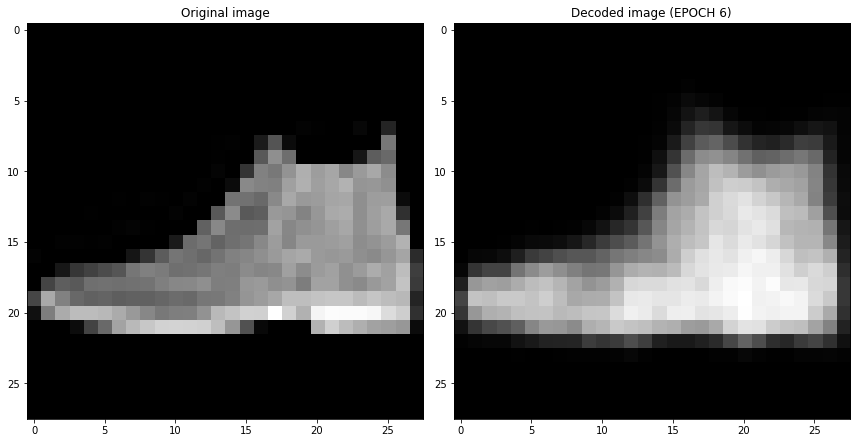

-----------------------
##  Epoch : 6  ##
-----------------------
 Training Loss 0.017878929216493953  Validation Loss 0.0177812110632658
-----------------------
##  Epoch : 7  ##
-----------------------
 Training Loss 0.017465569039291525  Validation Loss 0.017547855153679848
-----------------------
##  Epoch : 8  ##
-----------------------
 Training Loss 0.01711236814710688  Validation Loss 0.017098741605877876
-----------------------
##  Epoch : 9  ##
-----------------------
 Training Loss 0.016626068739656438  Validation Loss 0.016420451924204826
-----------------------
##  Epoch : 10  ##
-----------------------
 Training Loss 0.016205502408457563  Validation Loss 0.016097309067845345
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


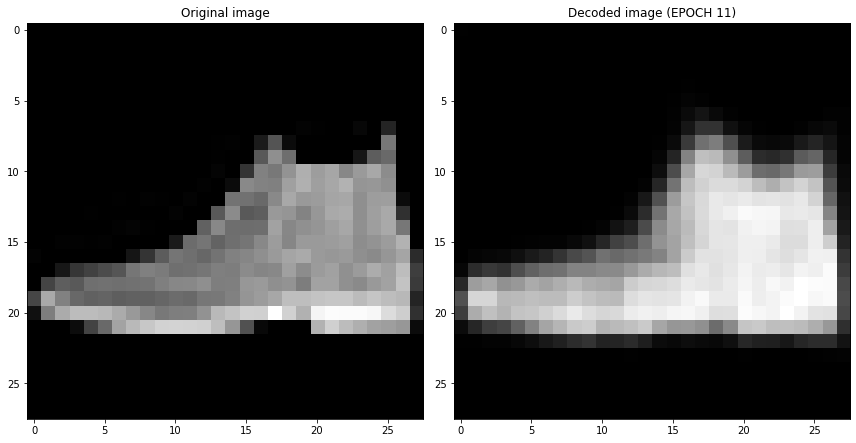

-----------------------
##  Epoch : 11  ##
-----------------------
 Training Loss 0.015823393493415192  Validation Loss 0.015791423618793488
-----------------------
##  Epoch : 12  ##
-----------------------
 Training Loss 0.015517857155584274  Validation Loss 0.015730297192931175
-----------------------
##  Epoch : 13  ##
-----------------------
 Training Loss 0.01531929344018089  Validation Loss 0.015428168699145317
-----------------------
##  Epoch : 14  ##
-----------------------
 Training Loss 0.015095331824998906  Validation Loss 0.015145441517233849
-----------------------
##  Epoch : 15  ##
-----------------------
 Training Loss 0.014852846675413721  Validation Loss 0.014997420832514763
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


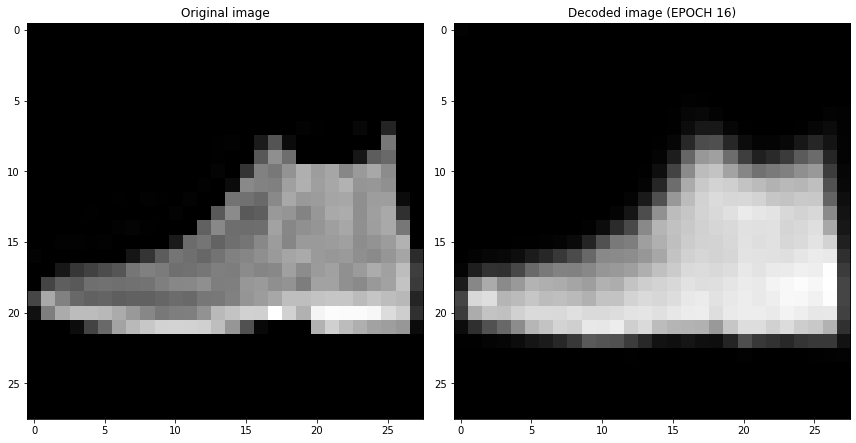

-----------------------
##  Epoch : 16  ##
-----------------------
 Training Loss 0.014625447481236559  Validation Loss 0.01463953498750925
-----------------------
##  Epoch : 17  ##
-----------------------
 Training Loss 0.014476123785084866  Validation Loss 0.014523912221193314
-----------------------
##  Epoch : 18  ##
-----------------------
 Training Loss 0.014316866166414099  Validation Loss 0.014284181408584118
-----------------------
##  Epoch : 19  ##
-----------------------
 Training Loss 0.01418871226462912  Validation Loss 0.014355135150253773
-----------------------
##  Epoch : 20  ##
-----------------------
 Training Loss 0.014059595712163347  Validation Loss 0.014132861979305744
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


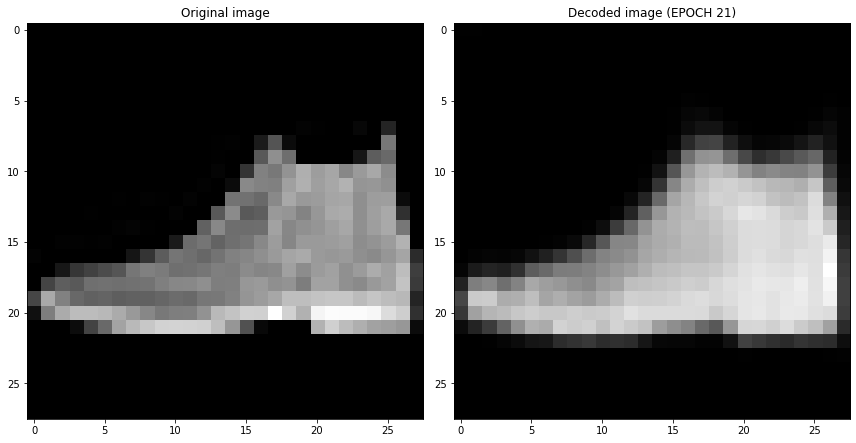

-----------------------
##  Epoch : 21  ##
-----------------------
 Training Loss 0.013926230937718076  Validation Loss 0.014121834188699722
-----------------------
##  Epoch : 22  ##
-----------------------
 Training Loss 0.013791396984077515  Validation Loss 0.013877836056053638
-----------------------
##  Epoch : 23  ##
-----------------------
 Training Loss 0.01372603362703577  Validation Loss 0.014142649248242378
-----------------------
##  Epoch : 24  ##
-----------------------
 Training Loss 0.01365642461608699  Validation Loss 0.013761037029325962
-----------------------
##  Epoch : 25  ##
-----------------------
 Training Loss 0.013540699677740006  Validation Loss 0.01377805694937706
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


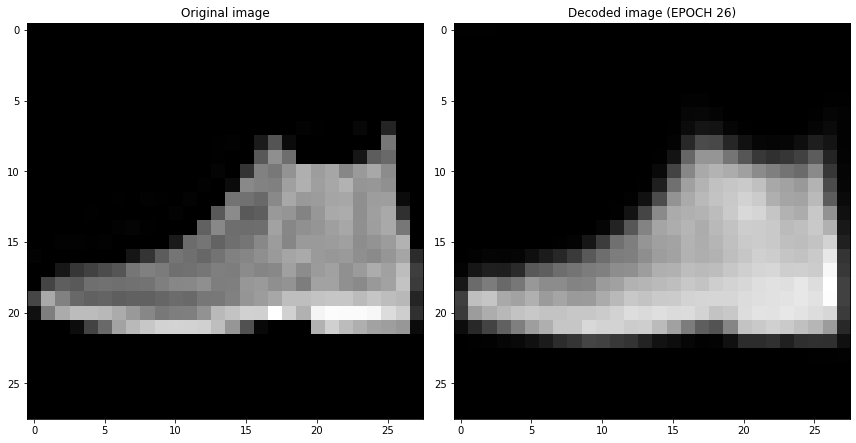

-----------------------
##  Epoch : 26  ##
-----------------------
 Training Loss 0.013461984452256498  Validation Loss 0.013592575676739216
-----------------------
##  Epoch : 27  ##
-----------------------
 Training Loss 0.013420672060802896  Validation Loss 0.013721263036131859
-----------------------
##  Epoch : 28  ##
-----------------------
 Training Loss 0.01336370513160178  Validation Loss 0.013573164120316505
-----------------------
##  Epoch : 29  ##
-----------------------
 Training Loss 0.013340189862758556  Validation Loss 0.013596923090517521

---------------- Ploting Training and Validation Loss ----------------

0.013340189862758556
0.013596923090517521


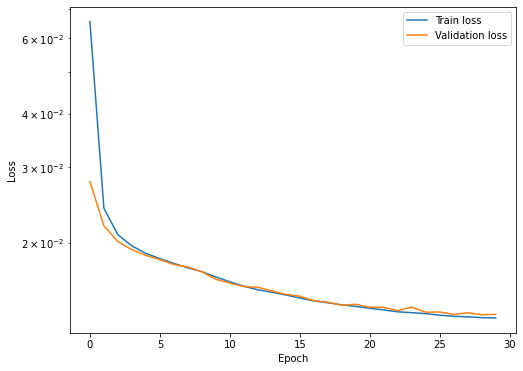

In [9]:
# parameters ={
#       "convh": 16,
#       "linh" : 64,
#       "lr" : 0.001,
#       "encoded_space_dim": 10


#   }


parameters ={
      "convh": 8,
      "linh" : 64,
      "lr" : 0.002,
      "encoded_space_dim": 10


  }

train_loss = train_model(parameters, device, epochs, loss_fn = loss_fn )

In [10]:

def objective(trial):
  parameters ={
      "convh":trial.suggest_int("convh", 16, 32),
      "linh" : trial.suggest_int("linh", 16, 32),
      "lr" : trial.suggest_float("lr", 1e-5, 1e-1, log=True),
      "encoded_space_dim": trial.suggest_int("encoded_space_dim", 2, 8)


  }



  train_loss = train_model(parameters, device,epochs, loss_fn = loss_fn )
  

  return np.mean(train_loss)

[I 2022-09-09 20:08:59,885] A new study created in memory with name: no-name-20f9f5ef-395d-4bca-8062-9427945cb310


Encoder Initializing !
Decoder Initialized !
-----------------------
##  Epoch : 0  ##
-----------------------
 Training Loss 0.13749145665701398  Validation Loss 0.08263052999973297
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


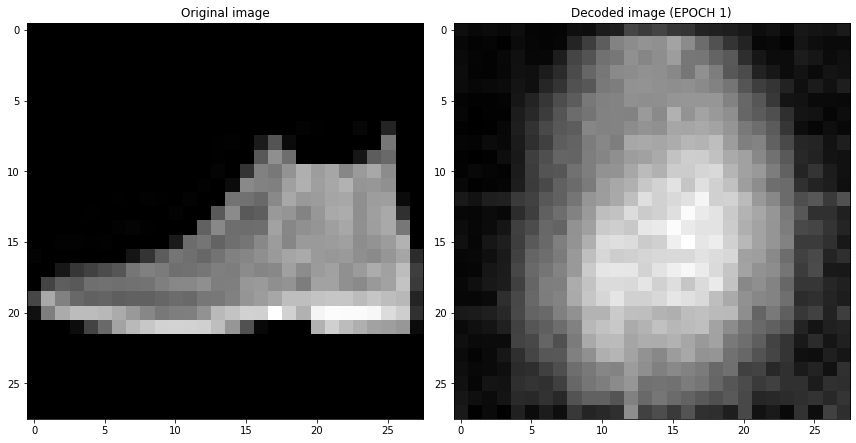

-----------------------
##  Epoch : 1  ##
-----------------------
 Training Loss 0.0683863656476457  Validation Loss 0.048871155828237534
-----------------------
##  Epoch : 2  ##
-----------------------
 Training Loss 0.043647331300568075  Validation Loss 0.03963732346892357
-----------------------
##  Epoch : 3  ##
-----------------------
 Training Loss 0.03730136924918662  Validation Loss 0.034846220165491104
-----------------------
##  Epoch : 4  ##
-----------------------
 Training Loss 0.03290663759442086  Validation Loss 0.031358521431684494
-----------------------
##  Epoch : 5  ##
-----------------------
 Training Loss 0.030412604390306675  Validation Loss 0.02952447719871998
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


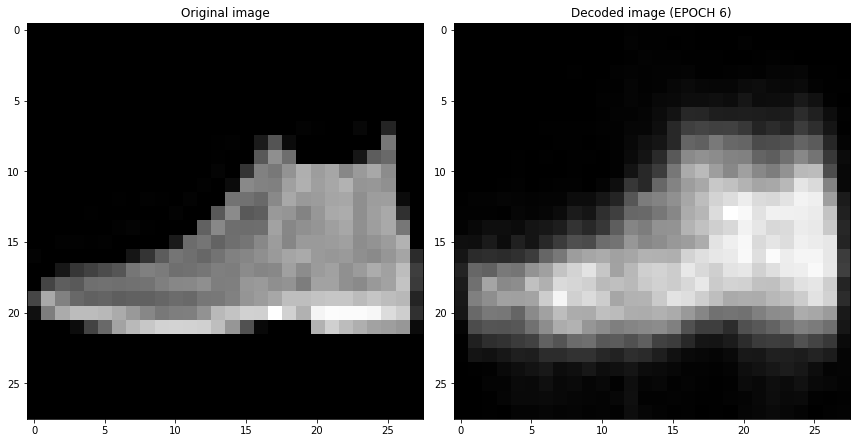

-----------------------
##  Epoch : 6  ##
-----------------------
 Training Loss 0.02888147497272238  Validation Loss 0.02823643945157528
-----------------------
##  Epoch : 7  ##
-----------------------
 Training Loss 0.02775352988788422  Validation Loss 0.02728072740137577
-----------------------
##  Epoch : 8  ##
-----------------------
 Training Loss 0.026848812964051328  Validation Loss 0.026496775448322296
-----------------------
##  Epoch : 9  ##
-----------------------
 Training Loss 0.0261206827265151  Validation Loss 0.025887515395879745
-----------------------
##  Epoch : 10  ##
-----------------------
 Training Loss 0.02553520017957434  Validation Loss 0.02539055608212948
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


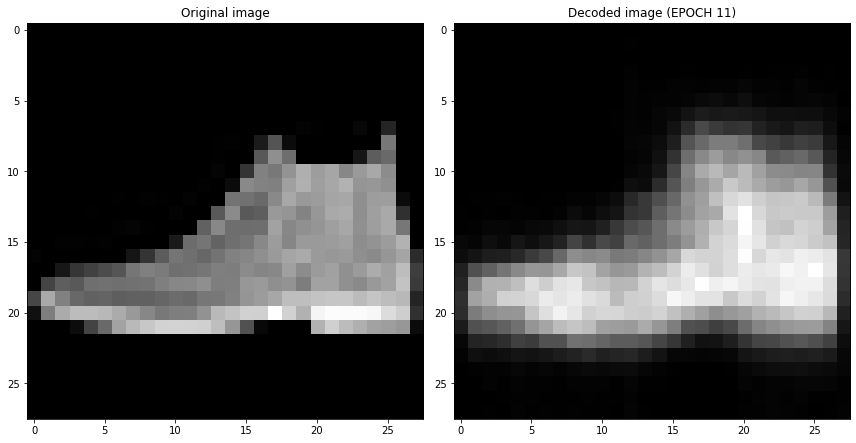

-----------------------
##  Epoch : 11  ##
-----------------------
 Training Loss 0.025082076824408897  Validation Loss 0.02493666484951973
-----------------------
##  Epoch : 12  ##
-----------------------
 Training Loss 0.024697931285234207  Validation Loss 0.02462158165872097
-----------------------
##  Epoch : 13  ##
-----------------------
 Training Loss 0.024370027135344263  Validation Loss 0.02430991642177105
-----------------------
##  Epoch : 14  ##
-----------------------
 Training Loss 0.024089068301180575  Validation Loss 0.024063391610980034
-----------------------
##  Epoch : 15  ##
-----------------------
 Training Loss 0.023832192787147582  Validation Loss 0.023820344358682632
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


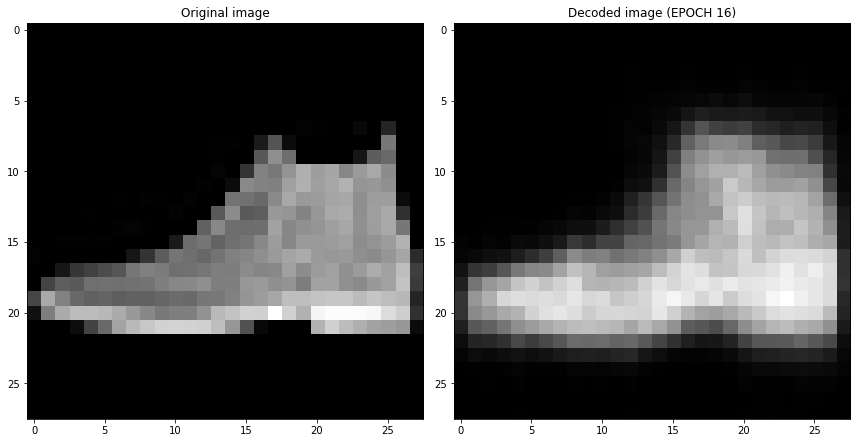

-----------------------
##  Epoch : 16  ##
-----------------------
 Training Loss 0.023621015337870477  Validation Loss 0.023640867322683334
-----------------------
##  Epoch : 17  ##
-----------------------
 Training Loss 0.023442444815597634  Validation Loss 0.023453256115317345
-----------------------
##  Epoch : 18  ##
-----------------------
 Training Loss 0.023232824743745176  Validation Loss 0.023290611803531647
-----------------------
##  Epoch : 19  ##
-----------------------
 Training Loss 0.023092316820266398  Validation Loss 0.023117005825042725
-----------------------
##  Epoch : 20  ##
-----------------------
 Training Loss 0.02293182815960113  Validation Loss 0.022985801100730896
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


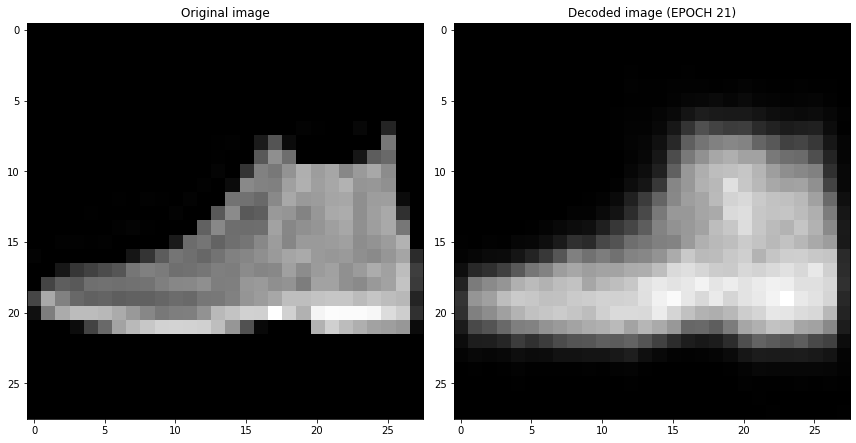

-----------------------
##  Epoch : 21  ##
-----------------------
 Training Loss 0.022780706670055998  Validation Loss 0.022830739617347717
-----------------------
##  Epoch : 22  ##
-----------------------
 Training Loss 0.022644842360565003  Validation Loss 0.022688284516334534
-----------------------
##  Epoch : 23  ##
-----------------------
 Training Loss 0.022510270164050956  Validation Loss 0.022598914802074432
-----------------------
##  Epoch : 24  ##
-----------------------
 Training Loss 0.02239818920163398  Validation Loss 0.022466227412223816
-----------------------
##  Epoch : 25  ##
-----------------------
 Training Loss 0.022265060816673524  Validation Loss 0.022345304489135742
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


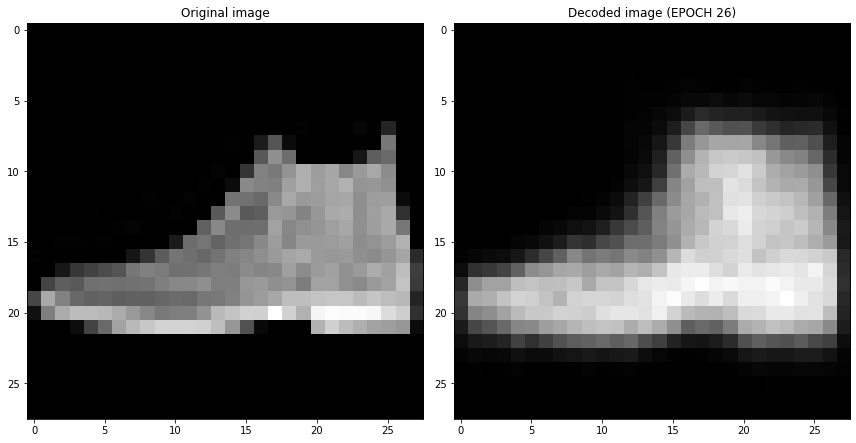

-----------------------
##  Epoch : 26  ##
-----------------------
 Training Loss 0.022158733121258146  Validation Loss 0.022239450365304947
-----------------------
##  Epoch : 27  ##
-----------------------
 Training Loss 0.022039261864537887  Validation Loss 0.022139010950922966
-----------------------
##  Epoch : 28  ##
-----------------------
 Training Loss 0.021929518022435777  Validation Loss 0.0220367182046175
-----------------------
##  Epoch : 29  ##
-----------------------
 Training Loss 0.02183964337281724  Validation Loss 0.02200622670352459

---------------- Ploting Training and Validation Loss ----------------

0.02183964337281724
0.02200622670352459


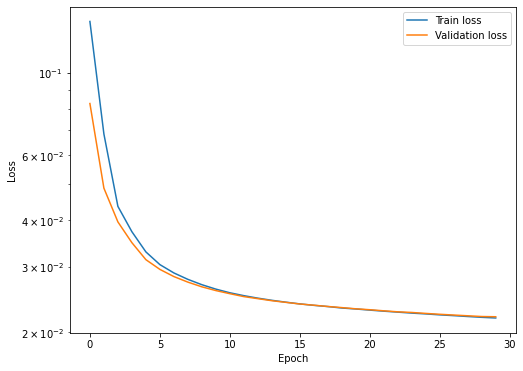

[I 2022-09-09 20:12:52,135] Trial 0 finished with value: 0.02183964337281724 and parameters: {'convh': 29, 'linh': 18, 'lr': 7.468083264735175e-05, 'encoded_space_dim': 5}. Best is trial 0 with value: 0.02183964337281724.


Encoder Initializing !
Decoder Initialized !
-----------------------
##  Epoch : 0  ##
-----------------------
 Training Loss 0.1566316771380445  Validation Loss 0.15045590698719025
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


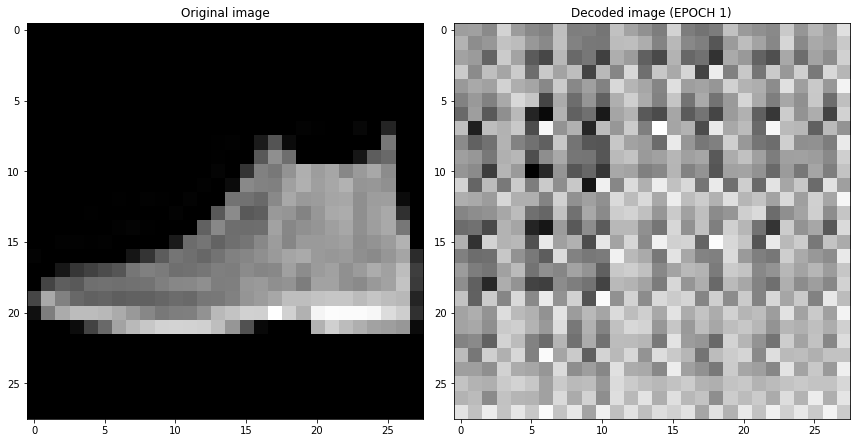

-----------------------
##  Epoch : 1  ##
-----------------------
 Training Loss 0.13145929365716083  Validation Loss 0.10448987782001495
-----------------------
##  Epoch : 2  ##
-----------------------
 Training Loss 0.09026128253404131  Validation Loss 0.07626552879810333
-----------------------
##  Epoch : 3  ##
-----------------------
 Training Loss 0.06870331878357745  Validation Loss 0.0641050785779953
-----------------------
##  Epoch : 4  ##
-----------------------
 Training Loss 0.062125382746787784  Validation Loss 0.05962233617901802
-----------------------
##  Epoch : 5  ##
-----------------------
 Training Loss 0.05748717374307044  Validation Loss 0.054732173681259155
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


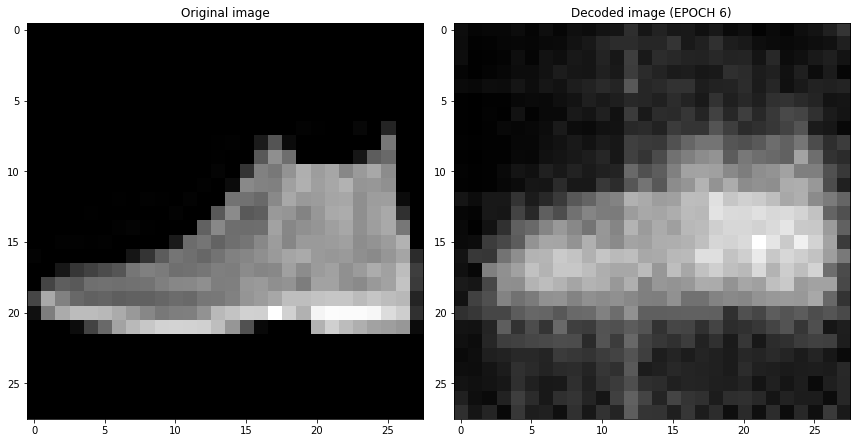

-----------------------
##  Epoch : 6  ##
-----------------------
 Training Loss 0.053377251929425176  Validation Loss 0.05169807747006416
-----------------------
##  Epoch : 7  ##
-----------------------
 Training Loss 0.05058443069140962  Validation Loss 0.04811649024486542
-----------------------
##  Epoch : 8  ##
-----------------------
 Training Loss 0.04573628314315004  Validation Loss 0.04398547485470772
-----------------------
##  Epoch : 9  ##
-----------------------
 Training Loss 0.04339330583176714  Validation Loss 0.04271022602915764
-----------------------
##  Epoch : 10  ##
-----------------------
 Training Loss 0.04238677543211491  Validation Loss 0.04194169491529465
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


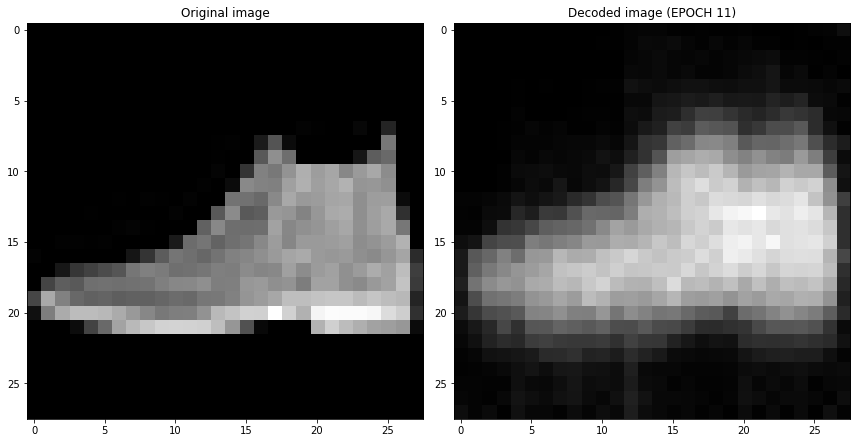

-----------------------
##  Epoch : 11  ##
-----------------------
 Training Loss 0.04172491651583225  Validation Loss 0.04137309640645981
-----------------------
##  Epoch : 12  ##
-----------------------
 Training Loss 0.04118204178645256  Validation Loss 0.04088696092367172
-----------------------
##  Epoch : 13  ##
-----------------------
 Training Loss 0.0407467838773068  Validation Loss 0.04050103947520256
-----------------------
##  Epoch : 14  ##
-----------------------
 Training Loss 0.04037296909918176  Validation Loss 0.040117207914590836
-----------------------
##  Epoch : 15  ##
-----------------------
 Training Loss 0.039996151800485366  Validation Loss 0.03977947682142258
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


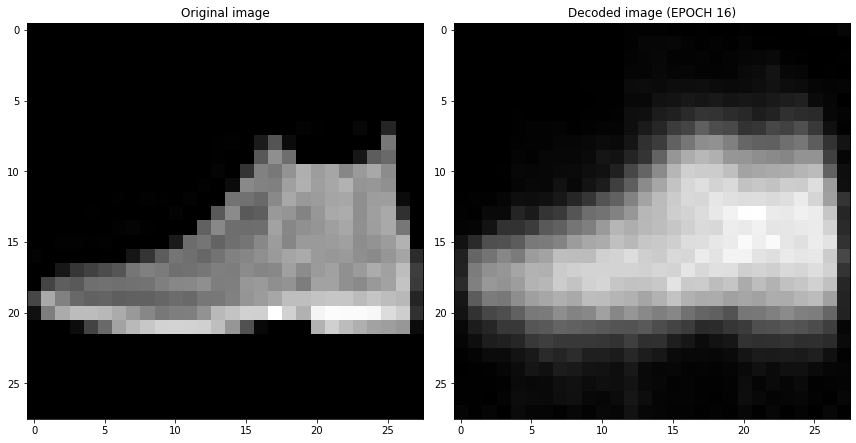

-----------------------
##  Epoch : 16  ##
-----------------------
 Training Loss 0.03967509442504416  Validation Loss 0.039454519748687744
-----------------------
##  Epoch : 17  ##
-----------------------
 Training Loss 0.03934839369451746  Validation Loss 0.0391436405479908
-----------------------
##  Epoch : 18  ##
-----------------------
 Training Loss 0.03904892241067075  Validation Loss 0.03884313255548477
-----------------------
##  Epoch : 19  ##
-----------------------
 Training Loss 0.03875974459533996  Validation Loss 0.038536880165338516
-----------------------
##  Epoch : 20  ##
-----------------------
 Training Loss 0.038459237823460966  Validation Loss 0.03824468329548836
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


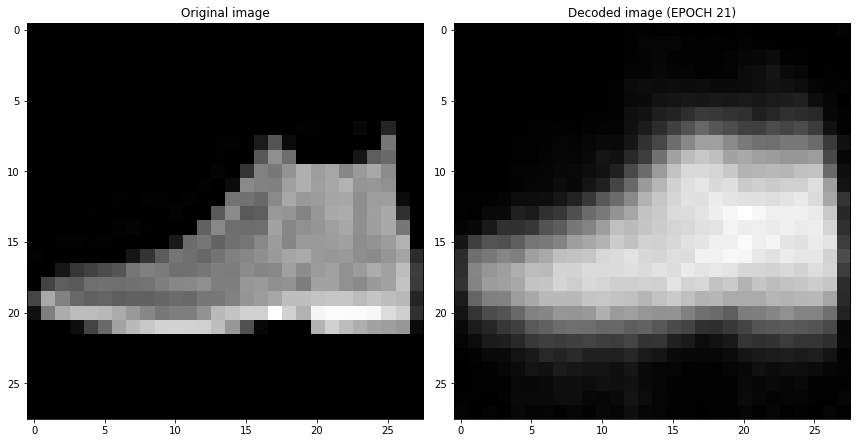

-----------------------
##  Epoch : 21  ##
-----------------------
 Training Loss 0.03814711069807093  Validation Loss 0.03792086988687515
-----------------------
##  Epoch : 22  ##
-----------------------
 Training Loss 0.037835765360517706  Validation Loss 0.03761327266693115
-----------------------
##  Epoch : 23  ##
-----------------------
 Training Loss 0.03752100797409707  Validation Loss 0.03728414326906204
-----------------------
##  Epoch : 24  ##
-----------------------
 Training Loss 0.03718148454072628  Validation Loss 0.03696683794260025
-----------------------
##  Epoch : 25  ##
-----------------------
 Training Loss 0.03688997174514101  Validation Loss 0.03666244447231293
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


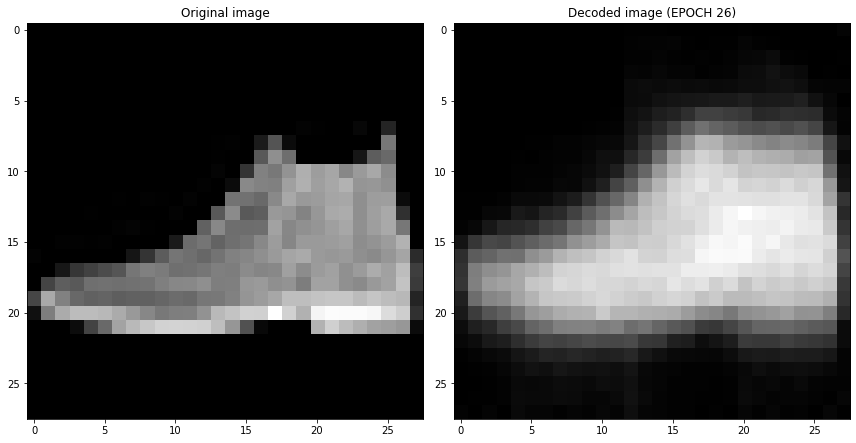

-----------------------
##  Epoch : 26  ##
-----------------------
 Training Loss 0.036594415123158315  Validation Loss 0.03638824075460434
-----------------------
##  Epoch : 27  ##
-----------------------
 Training Loss 0.03629038064403737  Validation Loss 0.03607552871108055
-----------------------
##  Epoch : 28  ##
-----------------------
 Training Loss 0.035990674762015645  Validation Loss 0.035773150622844696
-----------------------
##  Epoch : 29  ##
-----------------------
 Training Loss 0.035727707249052984  Validation Loss 0.03547704964876175

---------------- Ploting Training and Validation Loss ----------------

0.035727707249052984
0.03547704964876175


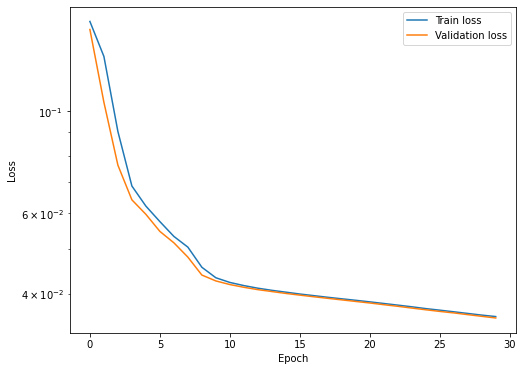

[I 2022-09-09 20:16:24,030] Trial 1 finished with value: 0.035727707249052984 and parameters: {'convh': 16, 'linh': 31, 'lr': 3.322770102268147e-05, 'encoded_space_dim': 2}. Best is trial 0 with value: 0.02183964337281724.


Encoder Initializing !
Decoder Initialized !
-----------------------
##  Epoch : 0  ##
-----------------------
 Training Loss 0.09264822237669153  Validation Loss 0.04355394095182419
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


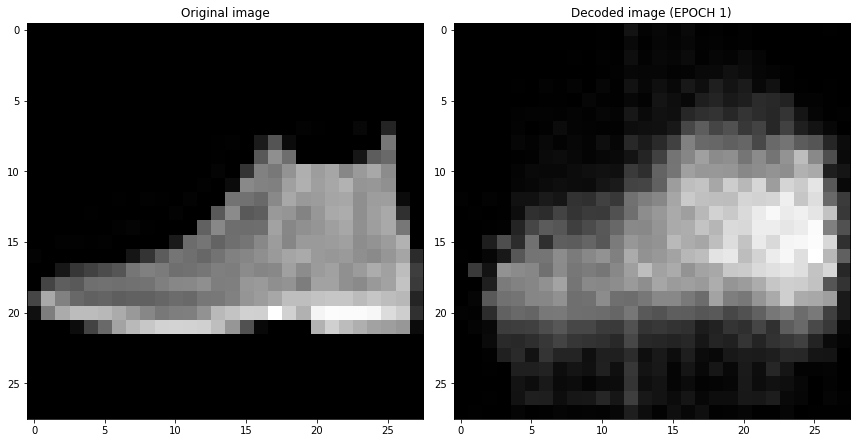

-----------------------
##  Epoch : 1  ##
-----------------------
 Training Loss 0.03506387292229115  Validation Loss 0.029420187696814537
-----------------------
##  Epoch : 2  ##
-----------------------
 Training Loss 0.026995457605795657  Validation Loss 0.025364289060235023
-----------------------
##  Epoch : 3  ##
-----------------------
 Training Loss 0.024381985848254347  Validation Loss 0.023751091212034225
-----------------------
##  Epoch : 4  ##
-----------------------
 Training Loss 0.0231627679093087  Validation Loss 0.02287382259964943
-----------------------
##  Epoch : 5  ##
-----------------------
 Training Loss 0.022386820772860912  Validation Loss 0.02212473936378956
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


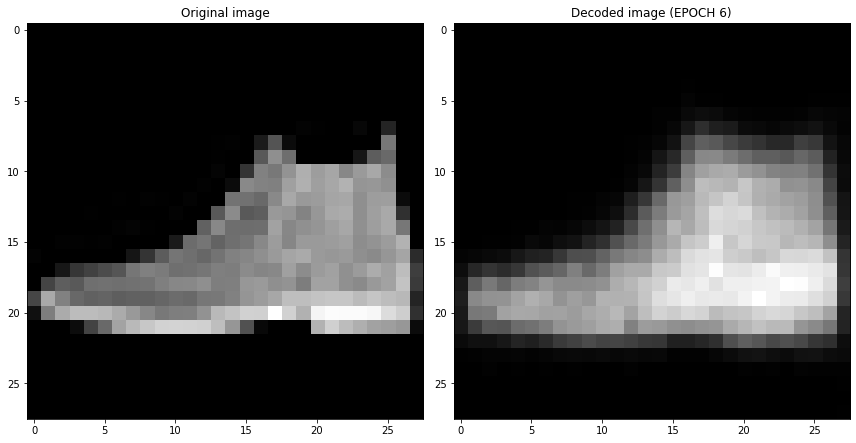

-----------------------
##  Epoch : 6  ##
-----------------------
 Training Loss 0.021815599501132966  Validation Loss 0.021848270669579506
-----------------------
##  Epoch : 7  ##
-----------------------
 Training Loss 0.02132704093893792  Validation Loss 0.021171679720282555
-----------------------
##  Epoch : 8  ##
-----------------------
 Training Loss 0.020748764435027506  Validation Loss 0.020553264766931534
-----------------------
##  Epoch : 9  ##
-----------------------
 Training Loss 0.020186644895596708  Validation Loss 0.020122967660427094
-----------------------
##  Epoch : 10  ##
-----------------------
 Training Loss 0.019807806230605917  Validation Loss 0.01969992369413376
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


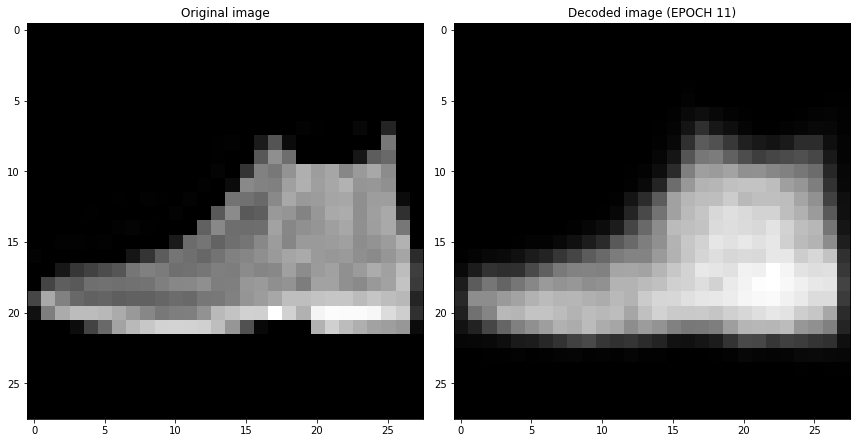

-----------------------
##  Epoch : 11  ##
-----------------------
 Training Loss 0.019461592936769447  Validation Loss 0.01943201944231987
-----------------------
##  Epoch : 12  ##
-----------------------
 Training Loss 0.019213944943027292  Validation Loss 0.01924547366797924
-----------------------
##  Epoch : 13  ##
-----------------------
 Training Loss 0.019007095591501988  Validation Loss 0.018981918692588806
-----------------------
##  Epoch : 14  ##
-----------------------
 Training Loss 0.018816677044997825  Validation Loss 0.018823958933353424
-----------------------
##  Epoch : 15  ##
-----------------------
 Training Loss 0.01865464739025907  Validation Loss 0.018677638843655586
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


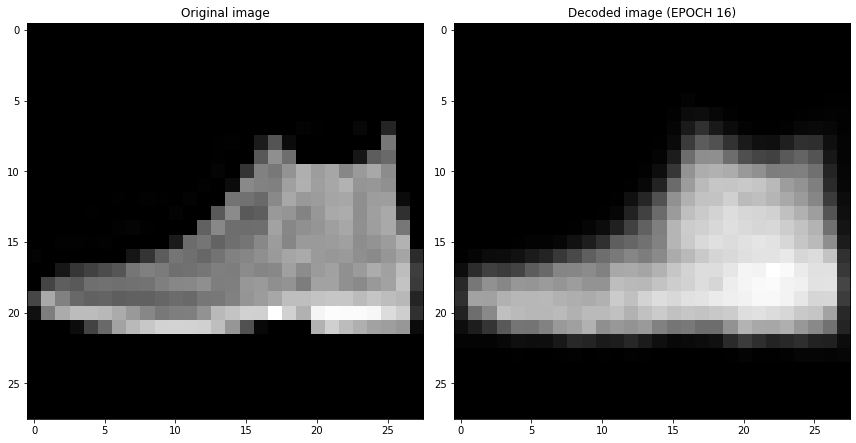

-----------------------
##  Epoch : 16  ##
-----------------------
 Training Loss 0.018494915137899682  Validation Loss 0.018579233437776566
-----------------------
##  Epoch : 17  ##
-----------------------
 Training Loss 0.018352591587190933  Validation Loss 0.018364040181040764
-----------------------
##  Epoch : 18  ##
-----------------------
 Training Loss 0.018240226599130226  Validation Loss 0.018272198736667633
-----------------------
##  Epoch : 19  ##
-----------------------
 Training Loss 0.01814510108942681  Validation Loss 0.01816556602716446
-----------------------
##  Epoch : 20  ##
-----------------------
 Training Loss 0.018017694251017367  Validation Loss 0.018100984394550323
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


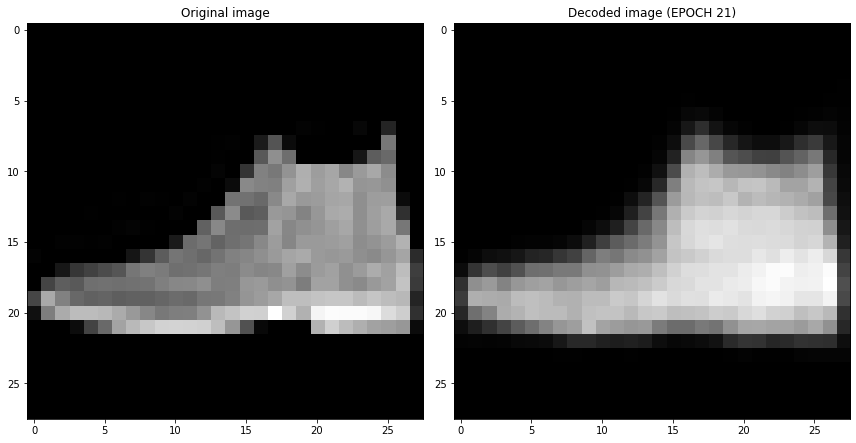

-----------------------
##  Epoch : 21  ##
-----------------------
 Training Loss 0.017920346550167877  Validation Loss 0.01791907288134098
-----------------------
##  Epoch : 22  ##
-----------------------
 Training Loss 0.017819966185600198  Validation Loss 0.017870869487524033
-----------------------
##  Epoch : 23  ##
-----------------------
 Training Loss 0.01774025969999902  Validation Loss 0.017779499292373657
-----------------------
##  Epoch : 24  ##
-----------------------
 Training Loss 0.017657004304705782  Validation Loss 0.017724016681313515
-----------------------
##  Epoch : 25  ##
-----------------------
 Training Loss 0.01758606622510768  Validation Loss 0.0175839401781559
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


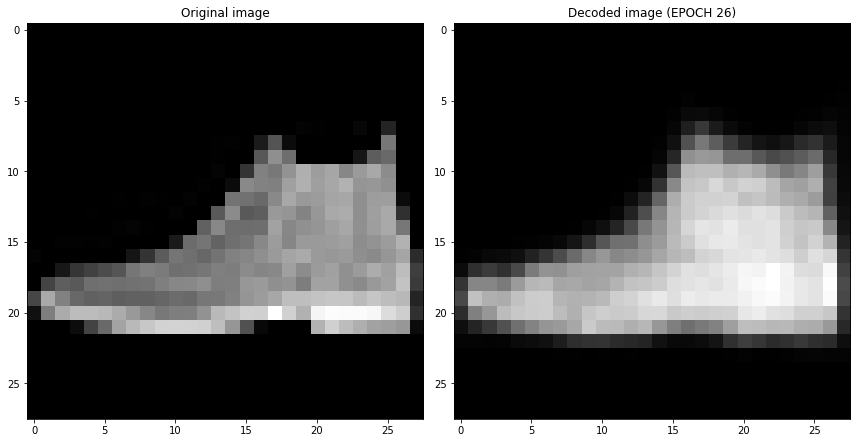

-----------------------
##  Epoch : 26  ##
-----------------------
 Training Loss 0.01748272528515217  Validation Loss 0.0176208708435297
-----------------------
##  Epoch : 27  ##
-----------------------
 Training Loss 0.017429020913674476  Validation Loss 0.017512468621134758
-----------------------
##  Epoch : 28  ##
-----------------------
 Training Loss 0.017347564215355733  Validation Loss 0.017528139054775238
-----------------------
##  Epoch : 29  ##
-----------------------
 Training Loss 0.017299419867390014  Validation Loss 0.017417512834072113

---------------- Ploting Training and Validation Loss ----------------

0.017299419867390014
0.017417512834072113


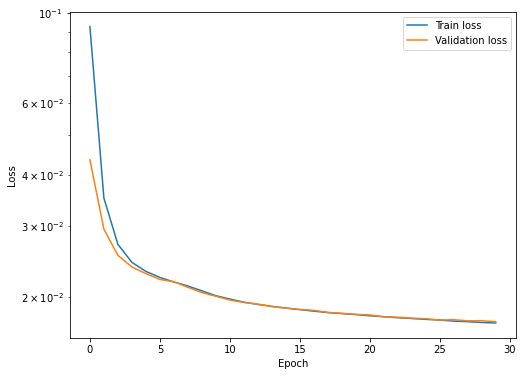

[I 2022-09-09 20:20:01,134] Trial 2 finished with value: 0.017299419867390014 and parameters: {'convh': 23, 'linh': 24, 'lr': 0.00034301475047209624, 'encoded_space_dim': 7}. Best is trial 2 with value: 0.017299419867390014.


Number of finished trials: 3
Best trial:
Value of trial:  0.017299419867390014
Best Parameter Found: 
    convh: 23
    linh: 24
    lr: 0.00034301475047209624
    encoded_space_dim: 7


In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, timeout=600)


print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("Value of trial: ", trial.value)

print("Best Parameter Found: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

{'convh': 23, 'linh': 24, 'lr': 0.00034301475047209624, 'encoded_space_dim': 7}
Encoder Initializing !
Decoder Initialized !
-----------------------
##  Epoch : 0  ##
-----------------------
 Training Loss 0.08308859294716348  Validation Loss 0.03729785606265068
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


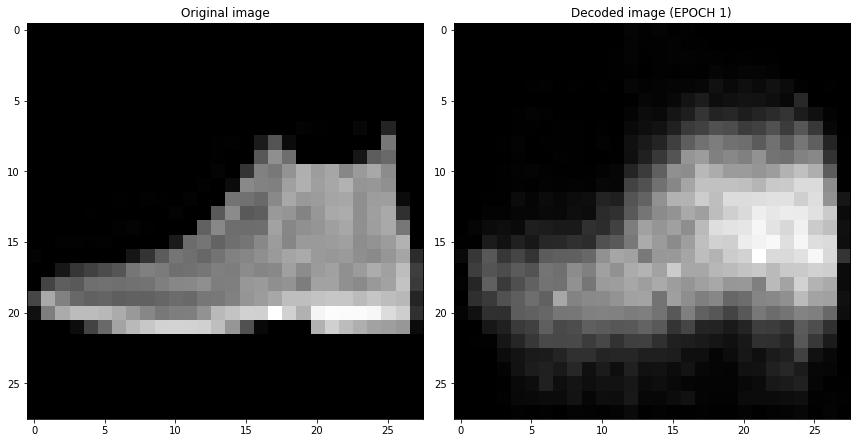

-----------------------
##  Epoch : 1  ##
-----------------------
 Training Loss 0.030937281187544477  Validation Loss 0.027539603412151337
-----------------------
##  Epoch : 2  ##
-----------------------
 Training Loss 0.025969992903001764  Validation Loss 0.024989038705825806
-----------------------
##  Epoch : 3  ##
-----------------------
 Training Loss 0.02396033095552566  Validation Loss 0.023277821019291878
-----------------------
##  Epoch : 4  ##
-----------------------
 Training Loss 0.02238090176214563  Validation Loss 0.021880077198147774
-----------------------
##  Epoch : 5  ##
-----------------------
 Training Loss 0.021254262066584952  Validation Loss 0.020982366055250168
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


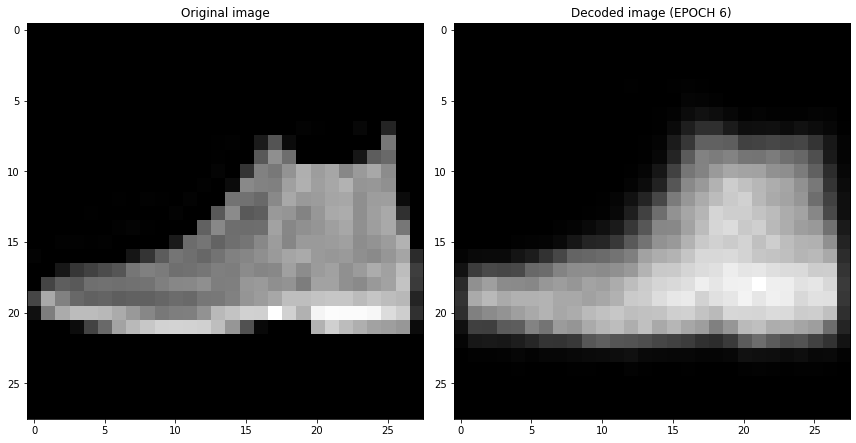

-----------------------
##  Epoch : 6  ##
-----------------------
 Training Loss 0.020542094285817856  Validation Loss 0.02039073407649994
-----------------------
##  Epoch : 7  ##
-----------------------
 Training Loss 0.020038784445917352  Validation Loss 0.02004854939877987
-----------------------
##  Epoch : 8  ##
-----------------------
 Training Loss 0.019622364925577285  Validation Loss 0.01963098719716072
-----------------------
##  Epoch : 9  ##
-----------------------
 Training Loss 0.01929785114653567  Validation Loss 0.019254552200436592
-----------------------
##  Epoch : 10  ##
-----------------------
 Training Loss 0.019052543118596076  Validation Loss 0.019078847020864487
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


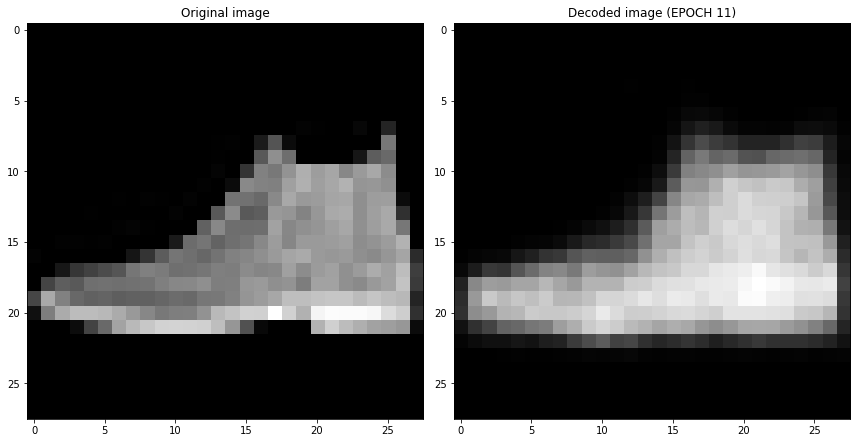

-----------------------
##  Epoch : 11  ##
-----------------------
 Training Loss 0.018798835543876  Validation Loss 0.018947185948491096
-----------------------
##  Epoch : 12  ##
-----------------------
 Training Loss 0.018601696106030585  Validation Loss 0.018608616665005684
-----------------------
##  Epoch : 13  ##
-----------------------
 Training Loss 0.018423674937258376  Validation Loss 0.018470250070095062
-----------------------
##  Epoch : 14  ##
-----------------------
 Training Loss 0.01827882615492699  Validation Loss 0.018317988142371178
-----------------------
##  Epoch : 15  ##
-----------------------
 Training Loss 0.018130206419749464  Validation Loss 0.01821601763367653
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


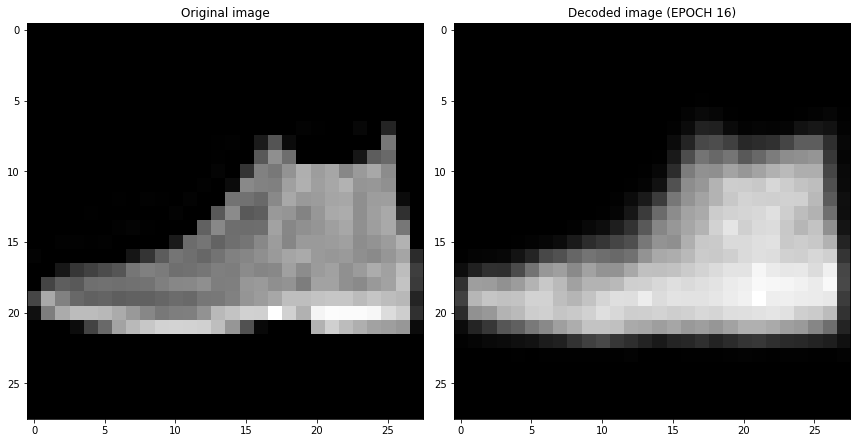

-----------------------
##  Epoch : 16  ##
-----------------------
 Training Loss 0.0180122564923256  Validation Loss 0.018051985651254654
-----------------------
##  Epoch : 17  ##
-----------------------
 Training Loss 0.017878267065958773  Validation Loss 0.018014000728726387
-----------------------
##  Epoch : 18  ##
-----------------------
 Training Loss 0.017770674333293386  Validation Loss 0.017989158630371094
-----------------------
##  Epoch : 19  ##
-----------------------
 Training Loss 0.017675906407864803  Validation Loss 0.017807409167289734
-----------------------
##  Epoch : 20  ##
-----------------------
 Training Loss 0.017580243810377223  Validation Loss 0.017664385959506035
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


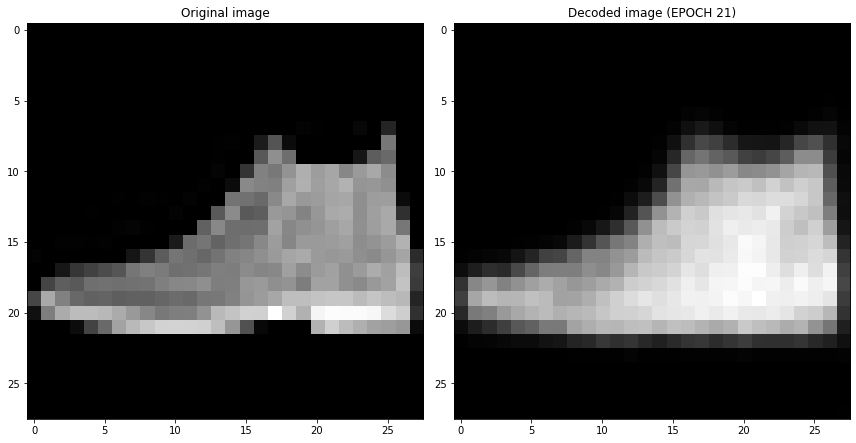

-----------------------
##  Epoch : 21  ##
-----------------------
 Training Loss 0.01748349737930805  Validation Loss 0.01756572723388672
-----------------------
##  Epoch : 22  ##
-----------------------
 Training Loss 0.017399359926422858  Validation Loss 0.017719030380249023
-----------------------
##  Epoch : 23  ##
-----------------------
 Training Loss 0.017328918978888937  Validation Loss 0.01746346801519394
-----------------------
##  Epoch : 24  ##
-----------------------
 Training Loss 0.017235460675301705  Validation Loss 0.017339294776320457
-----------------------
##  Epoch : 25  ##
-----------------------
 Training Loss 0.017180168608877253  Validation Loss 0.017255429178476334
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


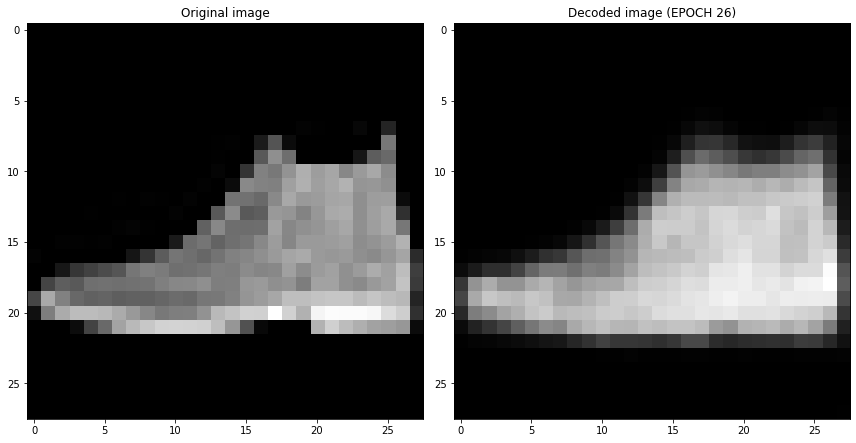

-----------------------
##  Epoch : 26  ##
-----------------------
 Training Loss 0.017104978863387667  Validation Loss 0.017210673540830612
-----------------------
##  Epoch : 27  ##
-----------------------
 Training Loss 0.017028614486310076  Validation Loss 0.017124414443969727
-----------------------
##  Epoch : 28  ##
-----------------------
 Training Loss 0.016970891640224355  Validation Loss 0.0171724334359169
-----------------------
##  Epoch : 29  ##
-----------------------
 Training Loss 0.016898739571742556  Validation Loss 0.017075752839446068

---------------- Ploting Training and Validation Loss ----------------

0.016898739571742556
0.017075752839446068


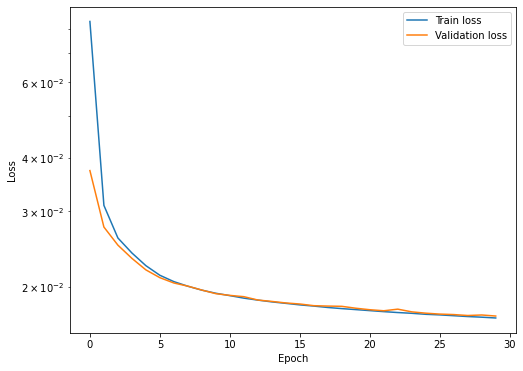

In [12]:
print(trial.params)
parameters = trial.params

train_loss = train_model(parameters, device, epochs, loss_fn = loss_fn )



#Classification

In [13]:
convh = parameters['convh']
linh = parameters['linh']
lr = parameters['lr']
encoded_space_dim = parameters['encoded_space_dim']
print(encoded_space_dim)
encoder = Encoder(encoded_space_dim , convh , linh)
encoder.load_state_dict(torch.load('model_encoder.bin'))
print(encoder)



7
Encoder Initializing !
Encoder(
  (conv2d): Sequential(
    (0): Conv2d(1, 23, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(23, 46, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(46, 92, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=828, out_features=24, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=24, out_features=7, bias=True)
  )
)


In [14]:
encoder_classify = nn.Sequential(
    encoder,
    nn.Dropout(0.2),
    nn.Linear(encoded_space_dim , 10)
)
print("------------ Classify Encoder -------------")
model = encoder_classify.to(device)

------------ Classify Encoder -------------


In [15]:
torch.manual_seed (20)
np.random.seed(20)
from torch.utils.data.sampler import SubsetRandomSampler



def dataset():
  transform = transforms.ToTensor()
  train_data = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transform)
  test_data  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transform)

  valid_size = 0.2
  batch_size = 256

  train = len(train_data)
  ind = list(range(train))
  
  np.random.shuffle(ind)
  split = int(np.floor(valid_size * train))
  train_idx, valid_idx = ind[split:], ind[:split]

  train_sampler = SubsetRandomSampler (train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx) 




  train_loader = DataLoader(train_data, sampler = train_sampler,batch_size = batch_size)
  valid_loader = DataLoader(train_data, sampler = valid_sampler ,batch_size = batch_size)

  test_loader = DataLoader(test_data, shuffle = False , batch_size = len(test_data))
  x_train , y_train = train_data.data, train_data.targets
  print('Shape of Training Data')
  print(x_train.shape , y_train.shape , sep='\n')

  
  print(f'\n Number of Training Samples : {len(train_idx)}')
  print(f' Number of Validation Samples : {len(valid_idx)}')

  print(f'Test Sample : {len(test_data)}')




# train_data = torchvision.datasets.FashionMNIST(root='./data', train=True ,download=True, transform = transforms.ToTensor())
# test_data = torchvision.datasets.FashionMNIST(root='./data', train=False ,download=True, transform = transforms.ToTensor())
# trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)



  return train_loader, valid_loader, test_loader , x_train , y_train

train_dataloader, valid_dataloader, test_dataloader , x_train , y_train = dataset()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw

Shape of Training Data
torch.Size([60000, 28, 28])
torch.Size([60000])

 Number of Training Samples : 48000
 Number of Validation Samples : 12000
Test Sample : 10000


In [16]:
class classifier():
  def __init__(self, encoder ,device , loss, optim , scheduler):
    self.encoder = encoder
    self.scheduler = scheduler

    self.device = device
    self.loss = loss
    self.optimizer = optim

  def train_step(self,dataloader):
    self.encoder.train()
    total_loss =0

    for image_batch, labels in train_dataloader: 

      image_batch = image_batch.to(self.device)
      labels = labels.to(self.device)
      encoded_data = self.encoder(image_batch)

      loss = self.loss(encoded_data, labels)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      total_loss += loss.item()
    return total_loss / len(train_dataloader)
      
  def validation_step(self , valid_dataloader):

    valid_loss = 0
    self.encoder.eval()

    with torch.no_grad(): 

      for image_batch, labels in valid_dataloader:
        image_batch = image_batch.to(self.device)
        labels = labels.to(self.device)

        encoded_data = self.encoder(image_batch)
        loss = self.loss(encoded_data, labels)

        valid_loss += loss.item()

        if self.scheduler :
          self.scheduler.step(valid_loss/len(valid_dataloader))
      return valid_loss / len(valid_dataloader)

#################
# EPOCH 0
#################
Epoch 00004: reducing learning rate of group 0 to 6.8603e-05.
Epoch 00007: reducing learning rate of group 0 to 1.3721e-05.
Epoch 00010: reducing learning rate of group 0 to 2.7441e-06.
Epoch 00013: reducing learning rate of group 0 to 5.4882e-07.
Epoch 00016: reducing learning rate of group 0 to 1.0976e-07.
Epoch 00019: reducing learning rate of group 0 to 2.1953e-08.
Epoch 00022: reducing learning rate of group 0 to 4.3906e-09.
 EPOCH 0, TRAIN LOSS 6.388074867268826, VAL LOSS 1.6014783179506342
#################
# EPOCH 1
#################
 EPOCH 1, TRAIN LOSS 1.7088565699597622, VAL LOSS 1.601253940704021
#################
# EPOCH 2
#################
 EPOCH 2, TRAIN LOSS 1.705536020563004, VAL LOSS 1.6011818596657286
#################
# EPOCH 3
#################
 EPOCH 3, TRAIN LOSS 1.7099276945946065, VAL LOSS 1.601601222728161
#################
# EPOCH 4
#################
 EPOCH 4, TRAIN LOSS 1.7099432558455365, VAL LOSS 1.601308153030

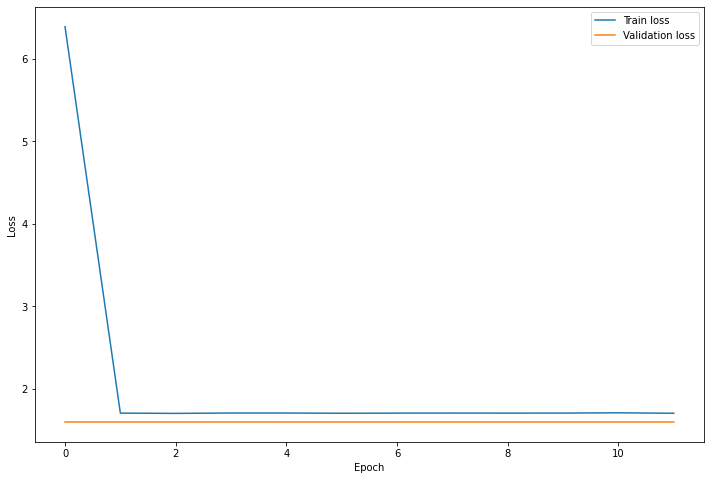

In [17]:
epochs=30



optimizer = torch.optim.Adam(encoder_classify.parameters(), lr=lr, weight_decay=1e-5 )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2,factor=0.2, threshold=1e-5,verbose=True)
loss = nn.CrossEntropyLoss()

classifier=classifier(model, device , loss, optimizer ,scheduler)

train_loss_log = []
val_loss_log = []

best_loss=np.inf
early_stopping = 3
early_stopping_counter=0
save_model = True
for epoch_num in range(epochs):
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')
  train_loss=classifier.train_step(train_dataloader)
  train_loss_log.append(train_loss)
  val_loss=classifier.validation_step(valid_dataloader)
  val_loss_log.append(val_loss)
  print(f" EPOCH {epoch_num}, TRAIN LOSS {train_loss}, VAL LOSS {val_loss}")
  if val_loss < best_loss :
    best_loss=val_loss
    early_stopping_counter=0
    if save_model:
      torch.save(model.state_dict(), f'model_classifier.bin')
  else :
    early_stopping_counter+=1
    if early_stopping_counter>early_stopping:
      break



# Plot losses
def plot_loss(train_loss_log,val_loss_log):
  plt.figure(figsize=(12,8))
  plt.plot(train_loss_log, label='Train loss')
  plt.plot(val_loss_log, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
plot_loss(train_loss_log,val_loss_log)

In [18]:

def testing( model ,criterion, test_loader):

  model.eval()  #set evaluation mode
  
  corrects  = 0.
  totals    = 0.
  test_loss = 0.
  
  with torch.no_grad():
      for s_batch in test_loader:
          
          x_batch = s_batch[0].to(device)      
          label_b = s_batch[1].to(device)       #import labels, move to device 
          
          outputs = model(x_batch)
          
          test_loss += criterion(outputs, label_b).item()
          
          _, predicted = torch.max(outputs.data, 1)
          totals += label_b.size(0)
          corrects += (predicted == label_b).sum().item()
      
      accuracy = (corrects / totals) * 100
      avg_test_loss = test_loss / totals
      
      print("Loss on Test Dataset:",avg_test_loss, "\n Accuracy:",accuracy)
          
  return avg_test_loss, accuracy


testing( model ,loss, test_dataloader)

Loss on Test Dataset: 0.0001611627459526062 
 Accuracy: 43.43


(0.0001611627459526062, 43.43)

#Denoiser AutoEncoder

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


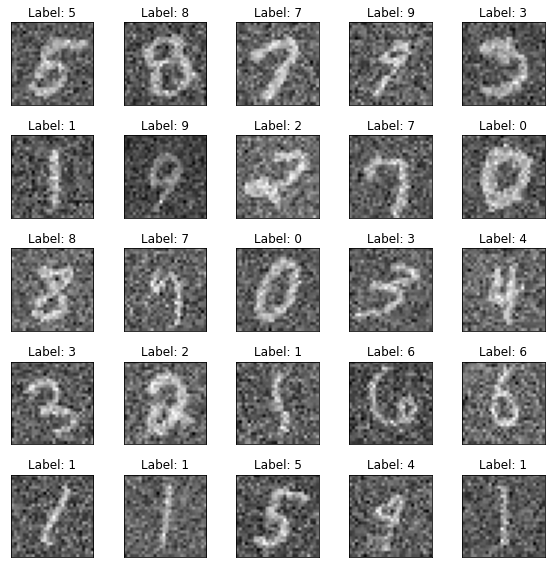

In [19]:
class Noise(object):
  def __init__(self, sigma):
      self.sigma=sigma

  def __call__(self, image):
    noise=np.random.normal(loc=0.,scale=self.sigma,size=image.shape).astype(np.float)
    image_noise=image+torch.tensor(noise)
    image_noise=image_noise.type(torch.float32)
    return {'image': image, 'noisy_image': image_noise}



sigma=1
train_transform=transforms.Compose([
                                    transforms.RandomRotation(20),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,),(0.3081,)),
                                    Noise(sigma)
                                    ])
test_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,),(0.3081,)),
                                    Noise(sigma)
                                    ])

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)



train_dataset.transform=train_transform
test_dataset.transform=test_transform

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data['image'].shape}")
print(f"\t Data: {batch_data['noisy_image'].shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data['image'].shape}")
print(f"\t Data: {batch_data['noisy_image'].shape}")
print(f"\t Labels: {batch_labels.shape}")



fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    data, label = random.choice(train_dataset)
    img=data['noisy_image'].squeeze(0)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [20]:
class denoise_engine:
  def __init__(self,model,optimizer,loss_fn,device):
    self.model=model
    self.optimizer=optimizer
    self.loss_fn=loss_fn
    self.device=device
  
  def train(self,dataloader):
    final_loss=0
    self.model["encoder"].train()
    self.model["decoder"].train()
    for sample_batched in dataloader:
      self.optimizer.zero_grad()
      images=sample_batched[0]['image'].to(self.device)
      noisy_images=sample_batched[0]['noisy_image'].to(self.device)
      codes=self.model["encoder"](noisy_images)
      outputs=self.model["decoder"](codes)
      loss= self.loss_fn(outputs,images)
      loss.backward()
      self.optimizer.step()
      final_loss+=loss.item()
    return final_loss/len(dataloader)
  def evaluate(self,dataloader):
    final_loss=0
    conc_out=[]
    conc_label=[]
    self.model['encoder'].eval()
    self.model['decoder'].eval()
    for sample_batched in dataloader:
      self.optimizer.zero_grad()
      images=sample_batched[0]['image'].to(self.device)
      noisy_images=sample_batched[0]['noisy_image'].to(self.device)
      codes=self.model["encoder"](noisy_images)
      outputs=self.model["decoder"](codes)
      loss= self.loss_fn(outputs,images)
      final_loss+=loss.item()
    return final_loss/len(dataloader)

Encoder Initializing !
Decoder Initialized !
#################
# EPOCH 0
#################


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


EPOCH 0, TRAIN LOSS 0.8761154973760564, VAL LOSS 0.7502789691090583
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


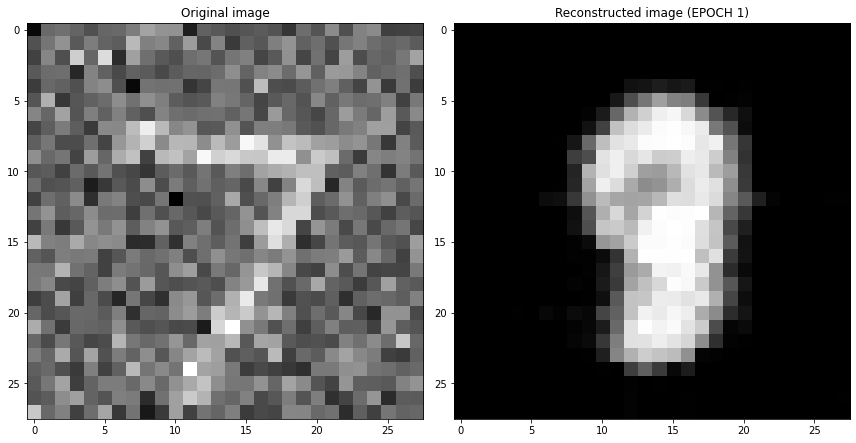

#################
# EPOCH 1
#################
EPOCH 1, TRAIN LOSS 0.6983395107248996, VAL LOSS 0.6588483899831772
#################
# EPOCH 2
#################
EPOCH 2, TRAIN LOSS 0.6409620170897626, VAL LOSS 0.62234675437212
#################
# EPOCH 3
#################
EPOCH 3, TRAIN LOSS 0.6237594145409604, VAL LOSS 0.6124818608164787
#################
# EPOCH 4
#################
EPOCH 4, TRAIN LOSS 0.6144700060499475, VAL LOSS 0.6035810053348541
#################
# EPOCH 5
#################
EPOCH 5, TRAIN LOSS 0.6068546959694395, VAL LOSS 0.598181027173996
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


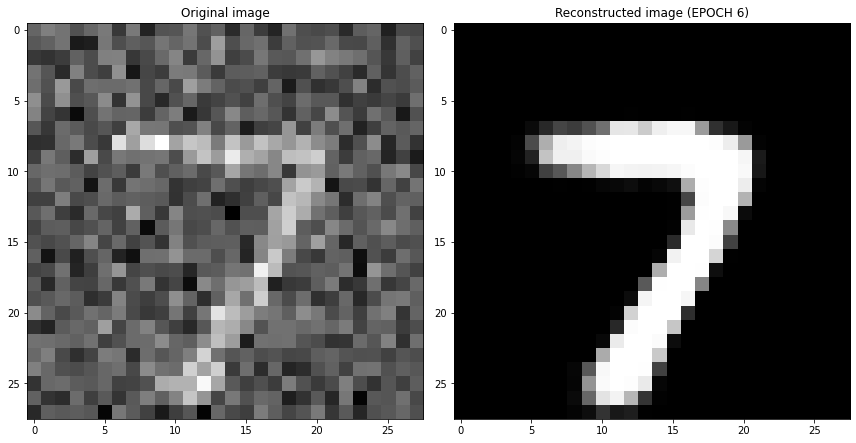

#################
# EPOCH 6
#################
EPOCH 6, TRAIN LOSS 0.601718552061852, VAL LOSS 0.5945635318756104
#################
# EPOCH 7
#################
EPOCH 7, TRAIN LOSS 0.597854073757821, VAL LOSS 0.5901541888713837
#################
# EPOCH 8
#################
EPOCH 8, TRAIN LOSS 0.5948573944416452, VAL LOSS 0.5873506277799606
#################
# EPOCH 9
#################
EPOCH 9, TRAIN LOSS 0.5921864392909598, VAL LOSS 0.5859393835067749
#################
# EPOCH 10
#################
EPOCH 10, TRAIN LOSS 0.5899359905973394, VAL LOSS 0.583363676071167
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


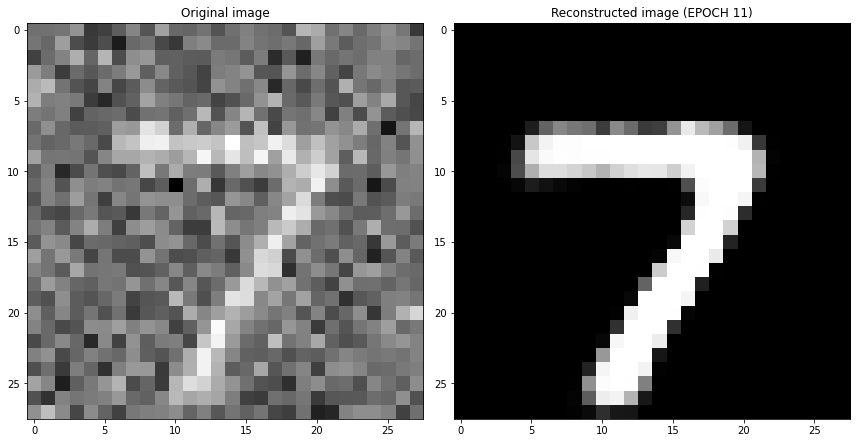

#################
# EPOCH 11
#################
EPOCH 11, TRAIN LOSS 0.5879629979742335, VAL LOSS 0.5815190836787224
#################
# EPOCH 12
#################
EPOCH 12, TRAIN LOSS 0.5860715538897413, VAL LOSS 0.5804395154118538
#################
# EPOCH 13
#################
EPOCH 13, TRAIN LOSS 0.5844869230655914, VAL LOSS 0.579148280620575
#################
# EPOCH 14
#################
EPOCH 14, TRAIN LOSS 0.5829137416596109, VAL LOSS 0.5773644775152207
#################
# EPOCH 15
#################
EPOCH 15, TRAIN LOSS 0.5816795582466937, VAL LOSS 0.5759471118450165
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


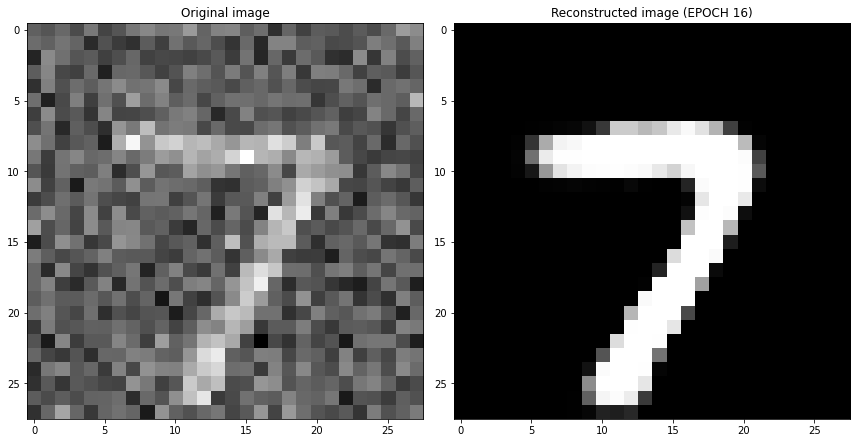

#################
# EPOCH 16
#################
EPOCH 16, TRAIN LOSS 0.5804156945106831, VAL LOSS 0.5754708766937255
#################
# EPOCH 17
#################
EPOCH 17, TRAIN LOSS 0.5793450454448131, VAL LOSS 0.5743059337139129
#################
# EPOCH 18
#################
EPOCH 18, TRAIN LOSS 0.5781723806198608, VAL LOSS 0.5729351937770844
#################
# EPOCH 19
#################
EPOCH 19, TRAIN LOSS 0.5774988894766949, VAL LOSS 0.571671299636364
#################
# EPOCH 20
#################
EPOCH 20, TRAIN LOSS 0.5766023648546097, VAL LOSS 0.571169427037239
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


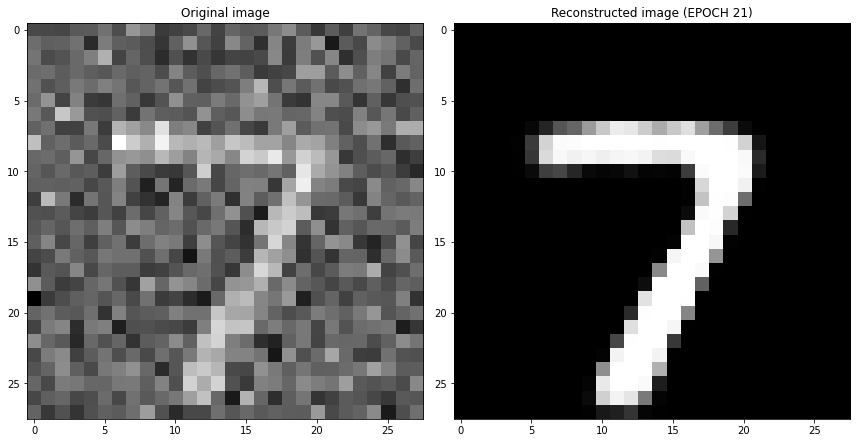

#################
# EPOCH 21
#################
EPOCH 21, TRAIN LOSS 0.5757641148059927, VAL LOSS 0.5704692617058754
#################
# EPOCH 22
#################
EPOCH 22, TRAIN LOSS 0.5751581493844378, VAL LOSS 0.5693217948079109
#################
# EPOCH 23
#################
EPOCH 23, TRAIN LOSS 0.5745669052955952, VAL LOSS 0.5690028041601181
#################
# EPOCH 24
#################
EPOCH 24, TRAIN LOSS 0.5736447215080261, VAL LOSS 0.5678668737411499
#################
# EPOCH 25
#################
EPOCH 25, TRAIN LOSS 0.5733952151968124, VAL LOSS 0.5681199669837952
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


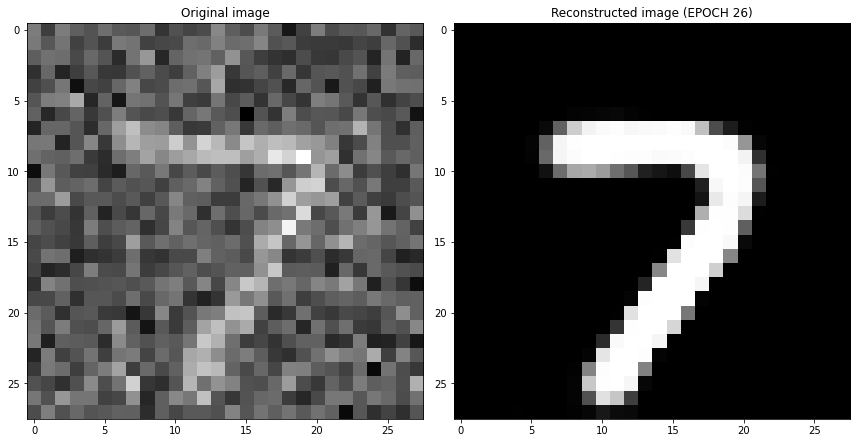

#################
# EPOCH 26
#################
EPOCH 26, TRAIN LOSS 0.5727833098553596, VAL LOSS 0.5670825526118278
#################
# EPOCH 27
#################
EPOCH 27, TRAIN LOSS 0.5725144726164797, VAL LOSS 0.5661369293928147
#################
# EPOCH 28
#################
EPOCH 28, TRAIN LOSS 0.5716850993481088, VAL LOSS 0.5656650185585022
#################
# EPOCH 29
#################
EPOCH 29, TRAIN LOSS 0.5711063040063736, VAL LOSS 0.5650314971804619


In [23]:
convh = parameters['convh']
linh = parameters['linh']
lr = parameters['lr']
encoded_space_dim = parameters['encoded_space_dim']
epochs = 30
encoder = Encoder(encoded_space_dim , convh , linh)
decoder = Decoder(encoded_space_dim , convh , linh)



encoder.to(device)
decoder.to(device)
params_to_optimize = [
  {'params': encoder.parameters()},
  {'params': decoder.parameters()}
]
model={"encoder":encoder,"decoder":decoder}
optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-4)
loss_fn=nn.MSELoss()
eng=denoise_engine(model,optimizer,loss_fn,device)
train_loss_log = []
val_loss_log = []

best_loss=np.inf
save_model=True
early_stopping = 5
early_stopping_counter=0
for epoch_num in range(epochs):
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')
  train_loss=eng.train(train_dataloader)
  train_loss_log.append(train_loss)
  val_loss=eng.evaluate(test_dataloader)
  val_loss_log.append(val_loss)
  print(f"EPOCH {epoch_num}, TRAIN LOSS {train_loss}, VAL LOSS {val_loss}")
  if val_loss < best_loss :
      best_loss=val_loss
      early_stopping_counter=0
  if save_model:
      torch.save(model["encoder"].state_dict(), f'model_denoise_encoder.bin')
      torch.save(model["decoder"].state_dict(), f'model_denoise_decoder.bin')
  else :
      early_stopping_counter+=1
  if early_stopping_counter>early_stopping:
      break
  if (epoch_num%5) == 0:
    img = test_dataset[0][0]['noisy_image'].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    print("reconstructed shape ",rec_img.shape)
    print("reconstructed shape ",img.shape)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch_num + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch_num + 1))
    plt.show()
    plt.close()


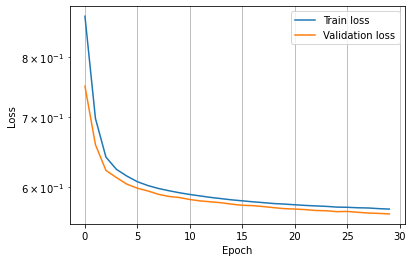

In [24]:
# Plot losses of the best model
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


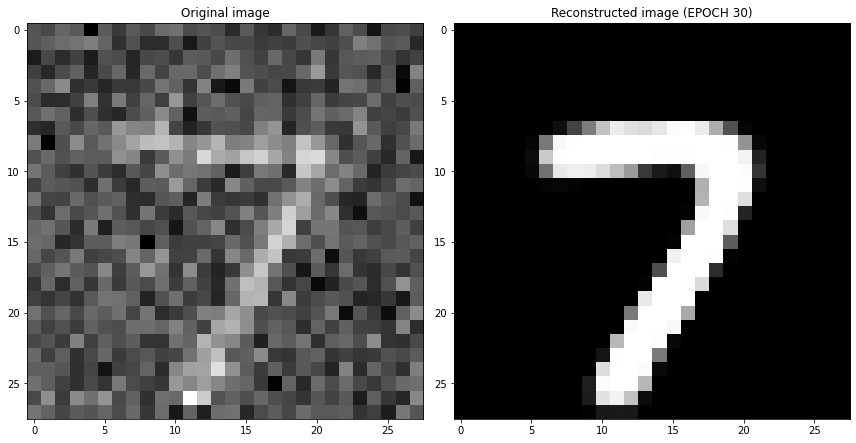

reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


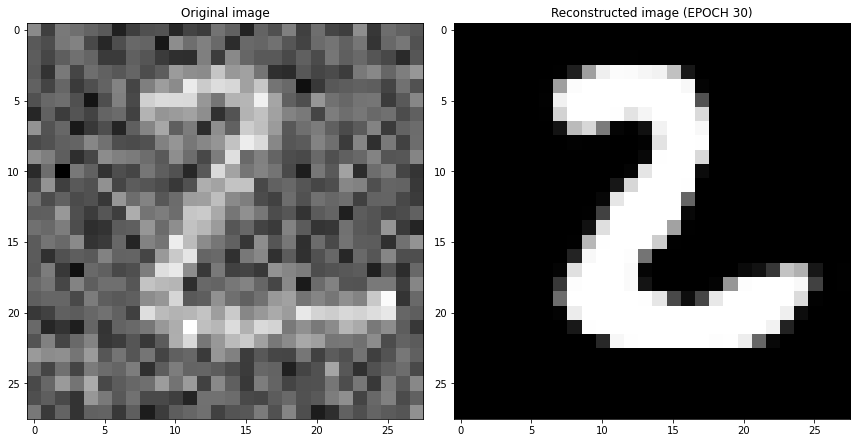

reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


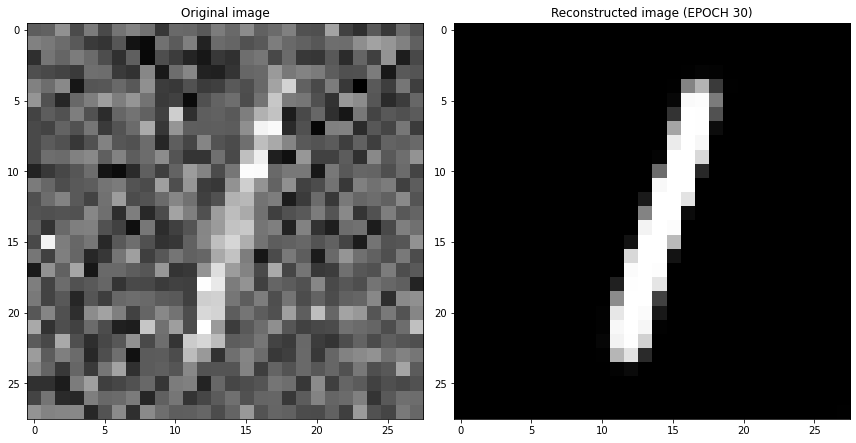

reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


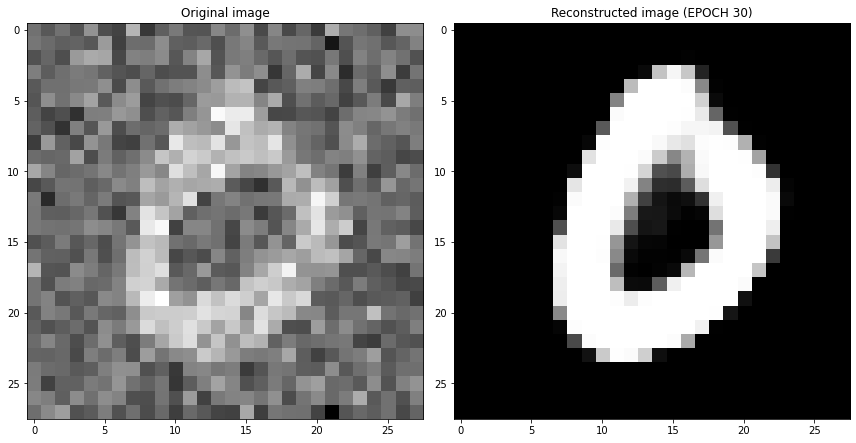

reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


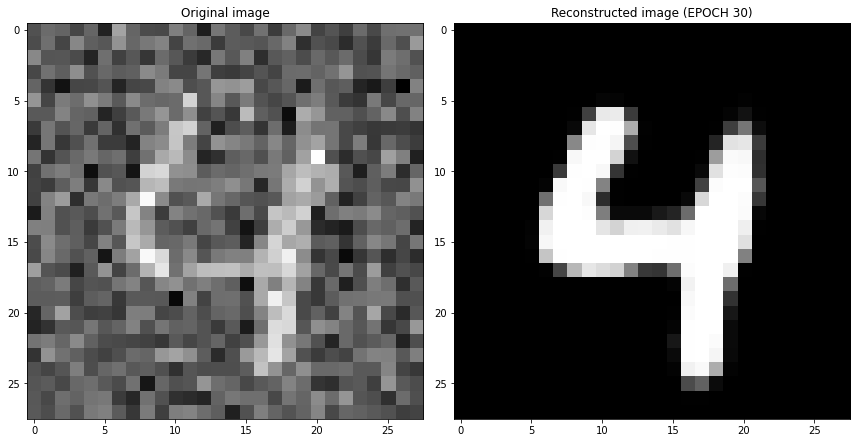

reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


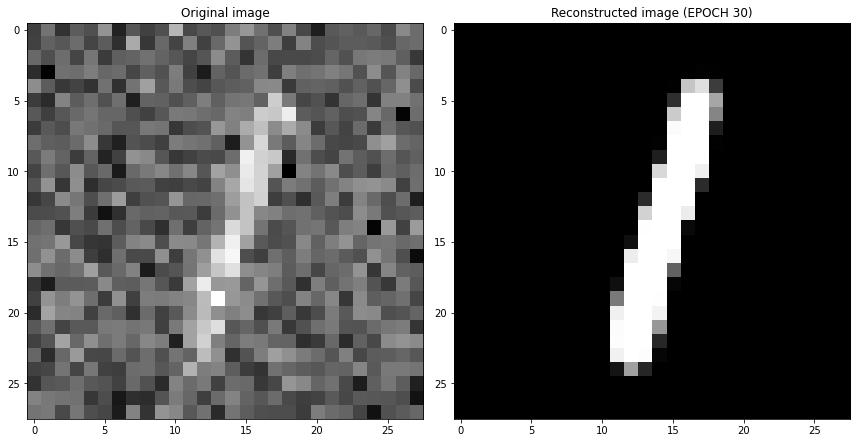

reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


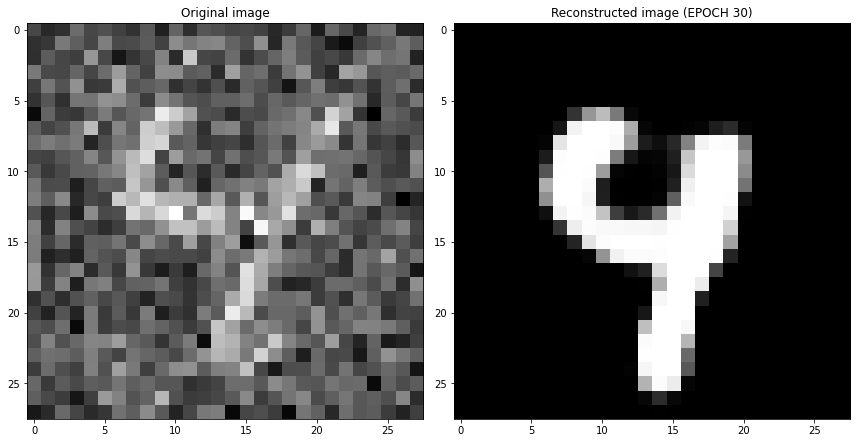

reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


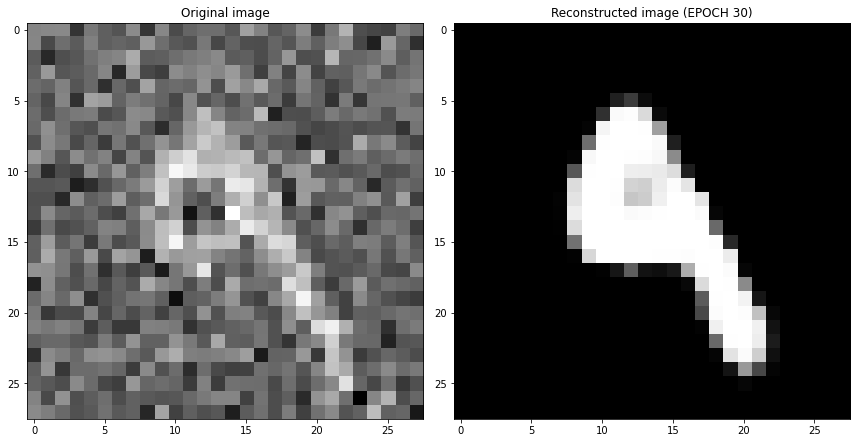

reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


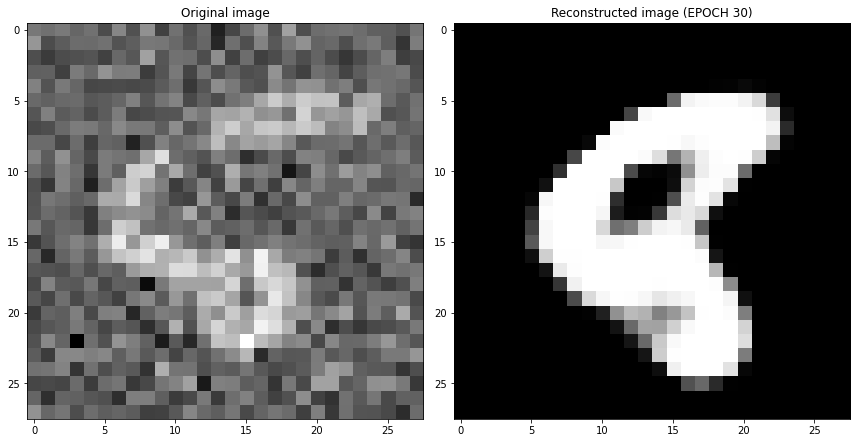

reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


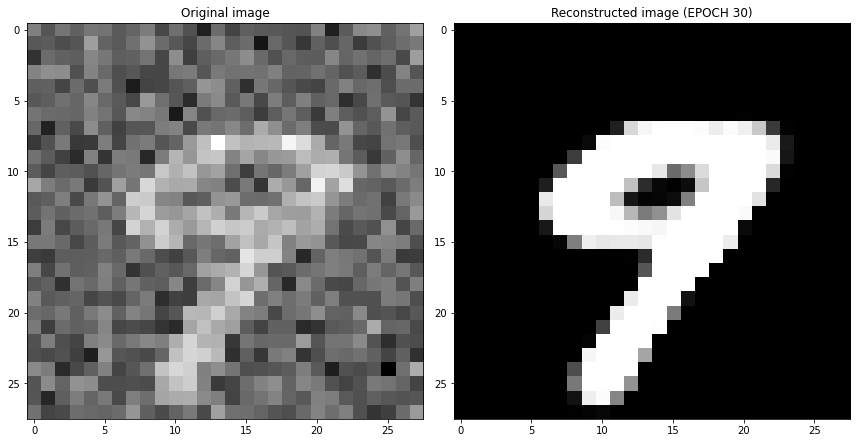

In [25]:
for i in range (10):
  img = test_dataset[i][0]['noisy_image'].unsqueeze(0).to(device)
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
      rec_img  = decoder(encoder(img))
  # Plot the reconstructed image
  print("reconstructed shape ",rec_img.shape)
  print("reconstructed shape ",img.shape)
  fig, axs = plt.subplots(1, 2, figsize=(12,6))
  axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[0].set_title('Original image')
  axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch_num + 1))
  plt.tight_layout()
  plt.pause(0.1)

#GAN Implementation

In [26]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device} \n')

Selected device: cuda 



In [27]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device} \n')




data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,)),
                                    ])
test_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,)),
                                    ])

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

train_dataset.transform=train_transform
test_dataset.transform=test_transform
batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")



image_size = 784
latent_size = 128


D = nn.Sequential(
    nn.Linear(image_size, 512),
    nn.LeakyReLU(0.2,inplace=True),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2,inplace=True),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.LeakyReLU(0.2,inplace=True),
    nn.Dropout(0.2),
    nn.Linear(128,1),
    nn.Sigmoid())


G = nn.Sequential(
    nn.Linear(latent_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh(),)

D.to(device)
G.to(device)


criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)



def train_discriminator(images):
    d_optimizer.zero_grad()
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(images.shape[0], 1).to(device)
    fake_labels = torch.zeros(images.shape[0], 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(images.shape[0], latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def train_generator():
    g_optimizer.zero_grad()
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    #fake_images = fake_images.reshape(batch_size, -1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images



import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

def denorm(x):
    out = (x +1) *0.5
    return out.clamp(0, 1)



from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in train_dataloader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))
#

sample_vectors = torch.randn(100, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))




# %%time

num_epochs = 5
batch_size=100
total_step = len(train_dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_dataloader):
        # Load a batch & transform to vectors
        images = images.reshape(images.shape[0], -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)




Selected device: cuda 

TRAIN BATCH SHAPE
	 Data: torch.Size([100, 1, 28, 28])
	 Labels: torch.Size([100])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
Saving fake_images-0000.png
Epoch [0/5], Step [200/600], d_loss: 1.7975, g_loss: 0.4715, D(x): 0.46, D(G(z)): 0.61
Epoch [0/5], Step [400/600], d_loss: 0.4758, g_loss: 2.5419, D(x): 0.74, D(G(z)): 0.15
Epoch [0/5], Step [600/600], d_loss: 1.8652, g_loss: 1.9470, D(x): 0.39, D(G(z)): 0.42
Saving fake_images-0001.png
Epoch [1/5], Step [200/600], d_loss: 0.0308, g_loss: 6.6968, D(x): 0.98, D(G(z)): 0.01
Epoch [1/5], Step [400/600], d_loss: 0.0020, g_loss: 11.0732, D(x): 1.00, D(G(z)): 0.00
Epoch [1/5], Step [600/600], d_loss: 0.0008, g_loss: 12.3357, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [2/5], Step [200/600], d_loss: 0.0004, g_loss: 13.0279, D(x): 1.00, D(G(z)): 0.00
Epoch [2/5], Step [400/600], d_loss: 0.0004, g_loss: 13.9242, D(x): 1.00, D(G(z)): 0.00
Epoch [2/5], Step [600/600]

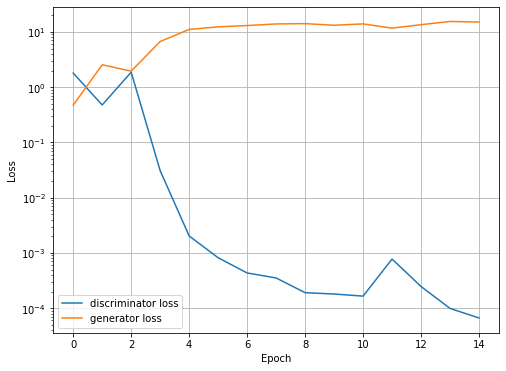

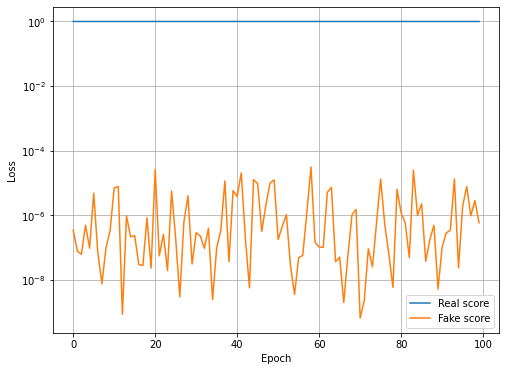

In [28]:
# Plot losses of the best model
plt.figure(figsize=(8,6))
plt.semilogy(d_losses, label='discriminator loss')
plt.semilogy(g_losses, label='generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()




# Plot losses of the best model
plt.figure(figsize=(8,6))
plt.semilogy(real_score.cpu().detach().numpy(), label='Real score')
plt.semilogy(fake_score.cpu().detach().numpy(), label='Fake score')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()